<a href="https://colab.research.google.com/github/Charlesbr101/projeto-redes-neurais/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

## Preparando bibliotecas

In [ ]:
!pip install imblearn
!pip3 install tensorflow_decision_forests --upgrade
!pip install keras-tuner -q
!pip install optuna
!pip install pykan==0.2.2
!pip install mljar-scikit-plot

import pandas as pd
from scipy import stats, special
import numpy as np
import math

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from scikitplot.metrics import plot_ks_statistic

from itertools import product
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.transforms
from torchvision.transforms import ToTensor
from torchvision.ops import MLP
from torch import optim

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import keras_tuner
import optuna as opt

from IPython.display import clear_output
import tensorflow_decision_forests as tfdf

from kan import KAN

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 28.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml

In [ ]:
from scipy import stats, special

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1R610tk2mrz2VWcOD2cYL3xk-ZLqUwp-m?usp=drive_link -O /content/database

Retrieving folder contents
Processing file 11Rzl81S2tDqEufdhHQ2zJrT51c8Vh4kM test.csv
Processing file 1UKKKRbrzbZDvpcQFYNGaqlrGur1RmkGP train.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=11Rzl81S2tDqEufdhHQ2zJrT51c8Vh4kM
To: /content/database/test.csv
100% 3.04M/3.04M [00:00<00:00, 181MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UKKKRbrzbZDvpcQFYNGaqlrGur1RmkGP
To: /content/database/train.csv
100% 12.2M/12.2M [00:00<00:00, 20.7MB/s]
Download completed


## preparando database

In [ ]:
train_df = pd.read_csv('database/train.csv', index_col=0)
test_df = pd.read_csv('database/test.csv', index_col=0)
train_df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


### Train Validation Split

In [ ]:
original_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

In [ ]:
train_df, validation_df = train_test_split(original_df,test_size= 0.25, stratify=original_df['satisfaction'])

print('original_df: ',len(original_df))
print('train_df size: ', len(train_df), "| validation_df size:", len(validation_df))
print(f'train_df: {len(train_df)/len(original_df)}%', f"| validation_df: {len(validation_df)/len(original_df)}%",)

original_df:  103904
train_df size:  77928 | validation_df size: 25976
train_df: 0.75% | validation_df: 0.25%


### Outliers

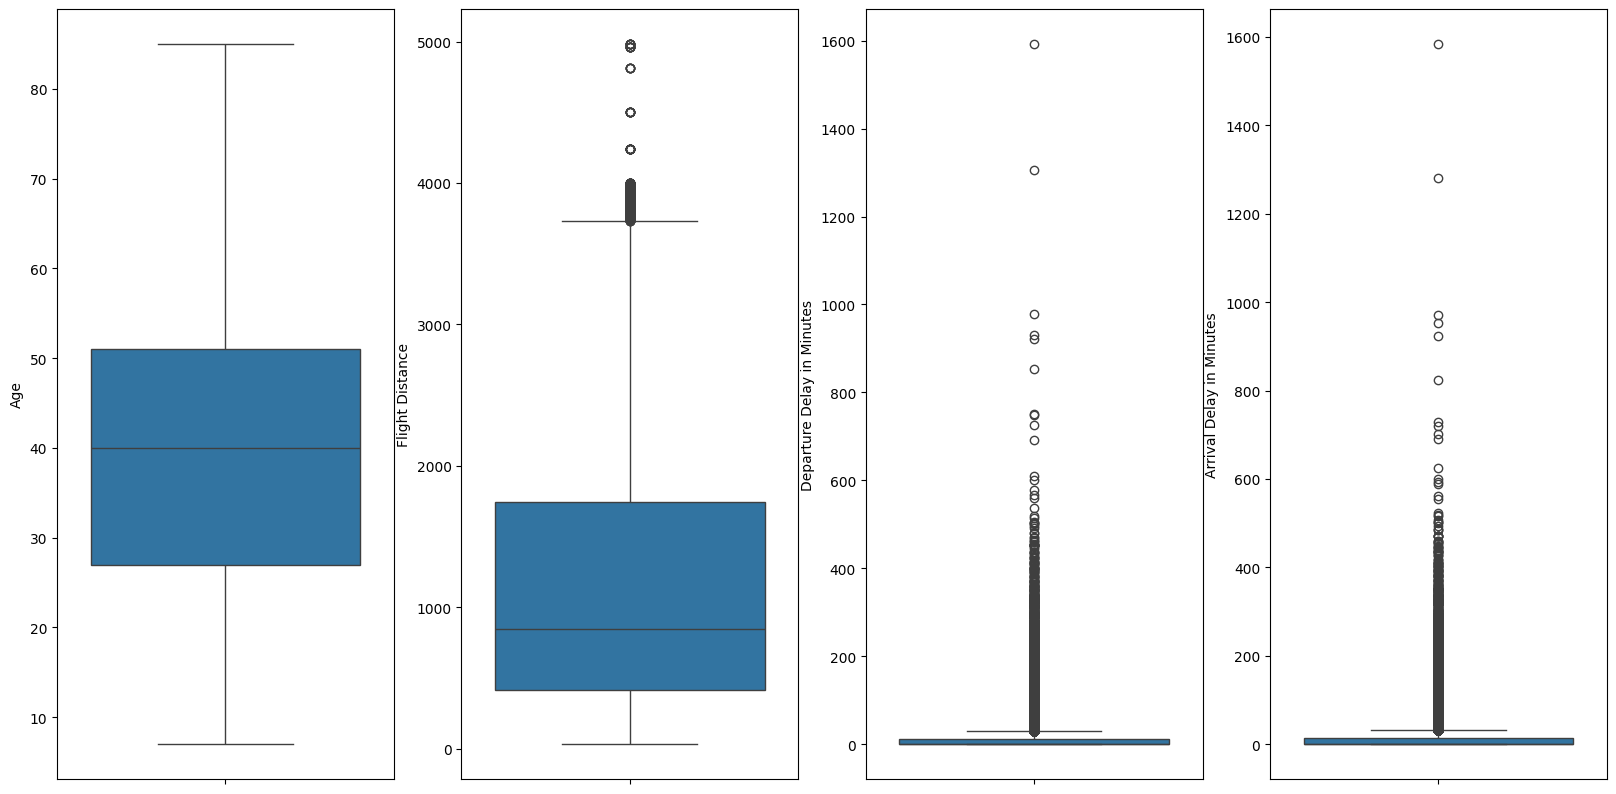

In [ ]:
train_df.reset_index(drop=True, inplace=True)

cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
plt.rcParams["figure.figsize"] = (20,10)

fig, axs = plt.subplots(1,len(cols))

for col, ax in zip(cols, axs):

  sns.boxplot(data=train_df[col], ax=ax)

Original DataFrame Shape: (77928, 23)
DataFrame Shape after Removing Outliers: (76226, 23)
Columns with z-score > 3:  ['Age', 'Flight Distance', 'Departure Delay in Minutes']


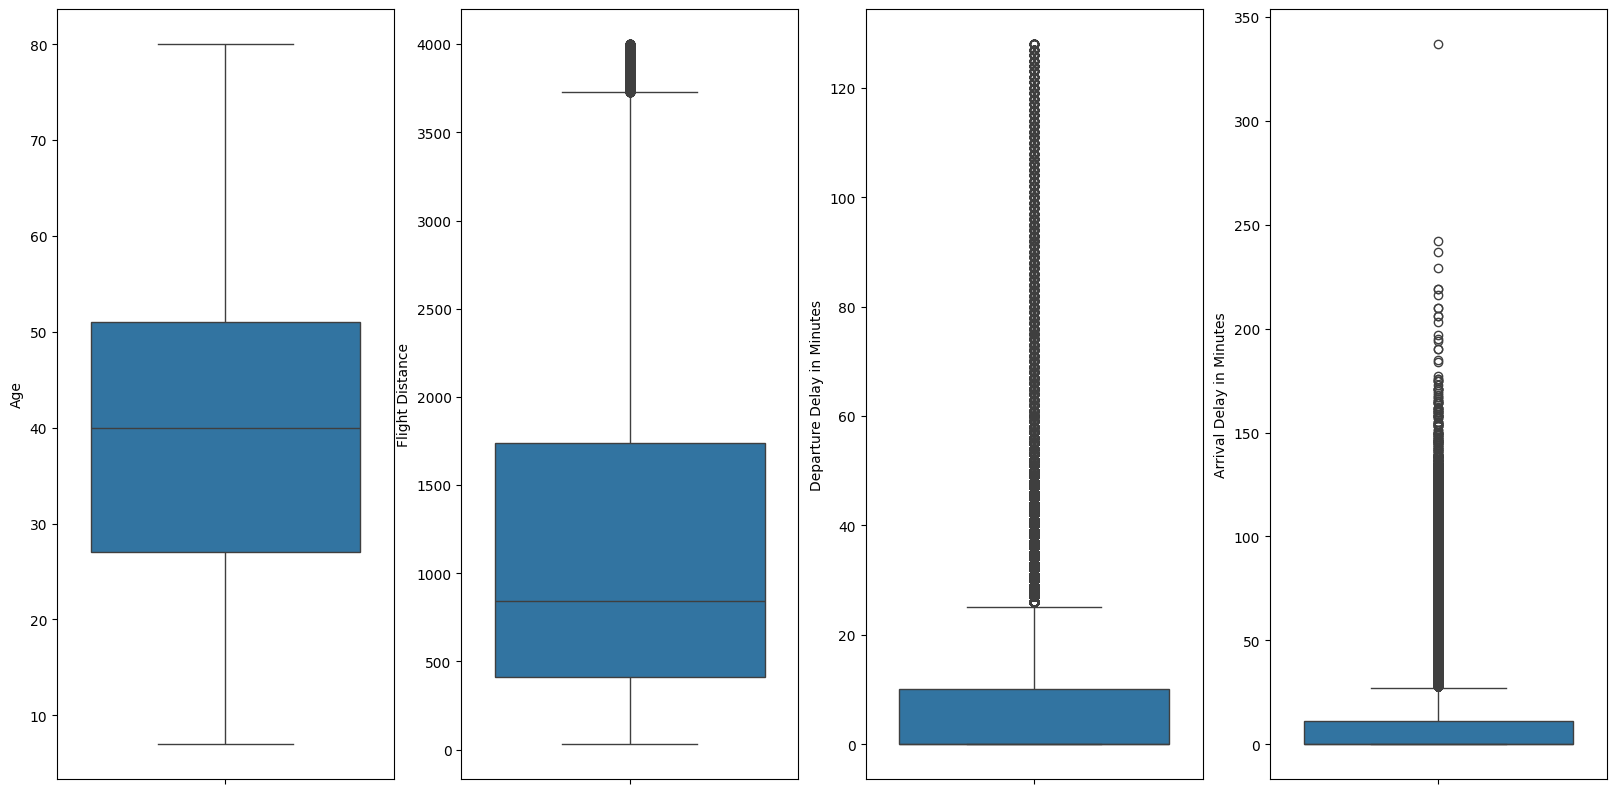

In [ ]:
print("Original DataFrame Shape:", train_df.shape)
z_score_col = []
for cl in cols:
    z = np.abs(stats.zscore(train_df[cl]))
    outlier_set = (np.where(z > 3)[0])
    train_df = train_df.drop(index=outlier_set)
    train_df.reset_index(drop=True, inplace=True)
    if len(outlier_set > 0):
        z_score_col.append(cl)


print("DataFrame Shape after Removing Outliers:", train_df.shape)
print('Columns with z-score > 3: ', z_score_col)

fig, axs = plt.subplots(1,len(cols))
for col, ax in zip(cols, axs):

  sns.boxplot(data=train_df[col], ax=ax)

### Enconding

#### Class Variable

In [ ]:
classes_dict = {
    'neutral or dissatisfied': 0,
    'satisfied': 1
}
def ord_encode(x):
    return classes_dict[x]

dec_class = 'satisfaction'
print('Before Encoding: ', train_df[dec_class].values)
train_df[dec_class] = train_df[dec_class].map(ord_encode)
validation_df[dec_class] = validation_df[dec_class].map(ord_encode)
test_df[dec_class] = test_df[dec_class].map(ord_encode)
print('After Encoding: ', train_df[dec_class].values)


Before Encoding:  ['satisfied' 'neutral or dissatisfied' 'satisfied' ... 'satisfied'
 'neutral or dissatisfied' 'satisfied']
After Encoding:  [1 0 1 ... 1 0 1]


#### One Hot Enconding

In [ ]:
one_hot_encoder_vars = ['Type of Travel', 'Gender', 'Customer Type']
test_df = pd.get_dummies(test_df, columns=one_hot_encoder_vars, drop_first=True)
validation_df = pd.get_dummies(validation_df, columns=one_hot_encoder_vars, drop_first=True)
train_df = pd.get_dummies(train_df, columns=one_hot_encoder_vars, drop_first=True)
train_df[['Type of Travel_Personal Travel', 'Gender_Male',  'Customer Type_disloyal Customer']]

,Type of Travel_Personal Travel,Gender_Male,Customer Type_disloyal Customer
0,False,True,False
1,False,True,False
2,False,False,False
3,True,False,False
4,False,False,False
...,...,...,...
76221,True,True,False
76222,False,True,False
76223,False,True,False
76224,True,True,False


#### Ordinal Enconding

In [ ]:
classes_dict = {
    'Eco': 0,
    'Eco Plus': 1,
    'Business': 2
}
def ord_encode(x):
    return classes_dict[x]

ordinal_encoder_vars = ['Class']
print('Before Encoding: ', train_df[ordinal_encoder_vars].values)
train_df[ordinal_encoder_vars] = train_df[ordinal_encoder_vars].applymap(ord_encode)
validation_df[ordinal_encoder_vars] = validation_df[ordinal_encoder_vars].applymap(ord_encode)
test_df[ordinal_encoder_vars] = test_df[ordinal_encoder_vars].applymap(ord_encode)
print('After Encoding: ', train_df[ordinal_encoder_vars].values)

Before Encoding:  [['Eco']
 ['Eco']
 ['Business']
 ...
 ['Business']
 ['Eco']
 ['Eco']]
After Encoding:  [[0]
 [0]
 [2]
 ...
 [2]
 [0]
 [0]]


<ipython-input-11-24e5a7481b54>:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_df[ordinal_encoder_vars] = train_df[ordinal_encoder_vars].applymap(ord_encode)
<ipython-input-11-24e5a7481b54>:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  validation_df[ordinal_encoder_vars] = validation_df[ordinal_encoder_vars].applymap(ord_encode)
<ipython-input-11-24e5a7481b54>:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_df[ordinal_encoder_vars] = test_df[ordinal_encoder_vars].applymap(ord_encode)


### Correlation

#### Continuous Variables

Needs to be done before Binning

<Axes: >

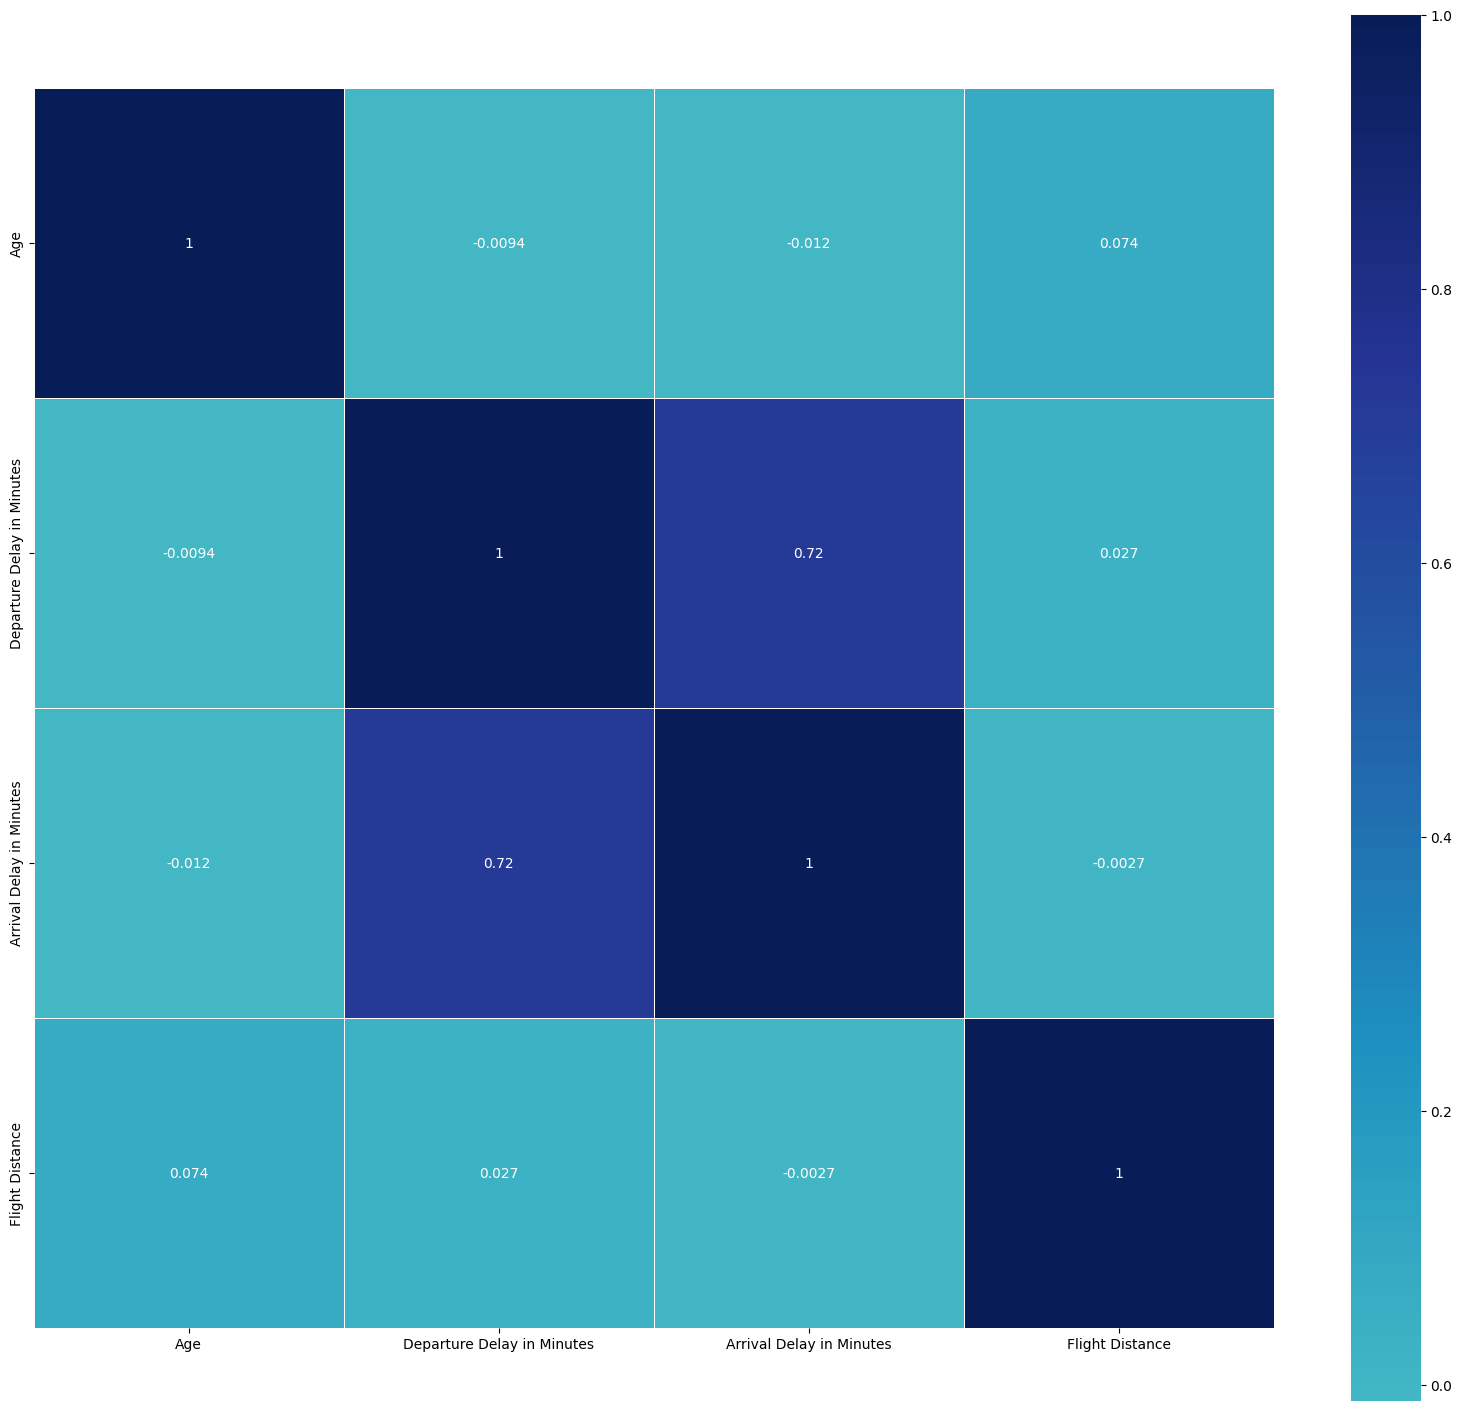

In [ ]:
columns = ['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']

corr = train_df[columns].corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, cmap="YlGnBu", center=0,
           square=True, linewidths=.5)

In [ ]:
corr

,Age,Departure Delay in Minutes,Arrival Delay in Minutes,Flight Distance
Age,1.000000,-0.009408,-0.011602,0.073665
Departure Delay in Minutes,-0.009408,1.000000,0.717185,0.026943
Arrival Delay in Minutes,-0.011602,0.717185,1.000000,-0.002710
Flight Distance,0.073665,0.026943,-0.002710,1.000000


#### Categorical Variables (Chi Squared Test)

In [ ]:
columns = ['Class', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'satisfaction', 'Type of Travel_Personal Travel', 'Gender_Male',
       'Customer Type_disloyal Customer']

print('Shape Before dropna: ', train_df[columns].shape)
df_corr = train_df[columns].dropna()
print('Shape After dropna: ', df_corr.shape)

cat_var_prod = list(product(columns,columns, repeat = 1))

result = []
for i in cat_var_prod:
       if i[0] != i[1]:
              result.append((i[0],i[1],list(stats.chi2_contingency(pd.crosstab(df_corr[i[0]], df_corr[i[1]])))[1]))
result

Shape Before dropna:  (76226, 19)
Shape After dropna:  (76226, 19)


[('Class', 'Inflight wifi service', 0.0),
 ('Class', 'Departure/Arrival time convenient', 0.0),
 ('Class', 'Ease of Online booking', 0.0),
 ('Class', 'Gate location', 0.0),
 ('Class', 'Food and drink', 4.779020979285074e-187),
 ('Class', 'Online boarding', 0.0),
 ('Class', 'Seat comfort', 0.0),
 ('Class', 'Inflight entertainment', 0.0),
 ('Class', 'On-board service', 0.0),
 ('Class', 'Leg room service', 0.0),
 ('Class', 'Baggage handling', 0.0),
 ('Class', 'Checkin service', 0.0),
 ('Class', 'Inflight service', 0.0),
 ('Class', 'Cleanliness', 0.0),
 ('Class', 'satisfaction', 0.0),
 ('Class', 'Type of Travel_Personal Travel', 0.0),
 ('Class', 'Gender_Male', 0.0021847622377531542),
 ('Class', 'Customer Type_disloyal Customer', 2.2493601695305067e-238),
 ('Inflight wifi service', 'Class', 0.0),
 ('Inflight wifi service', 'Departure/Arrival time convenient', 0.0),
 ('Inflight wifi service', 'Ease of Online booking', 0.0),
 ('Inflight wifi service', 'Gate location', 0.0),
 ('Inflight wifi s

<Axes: >

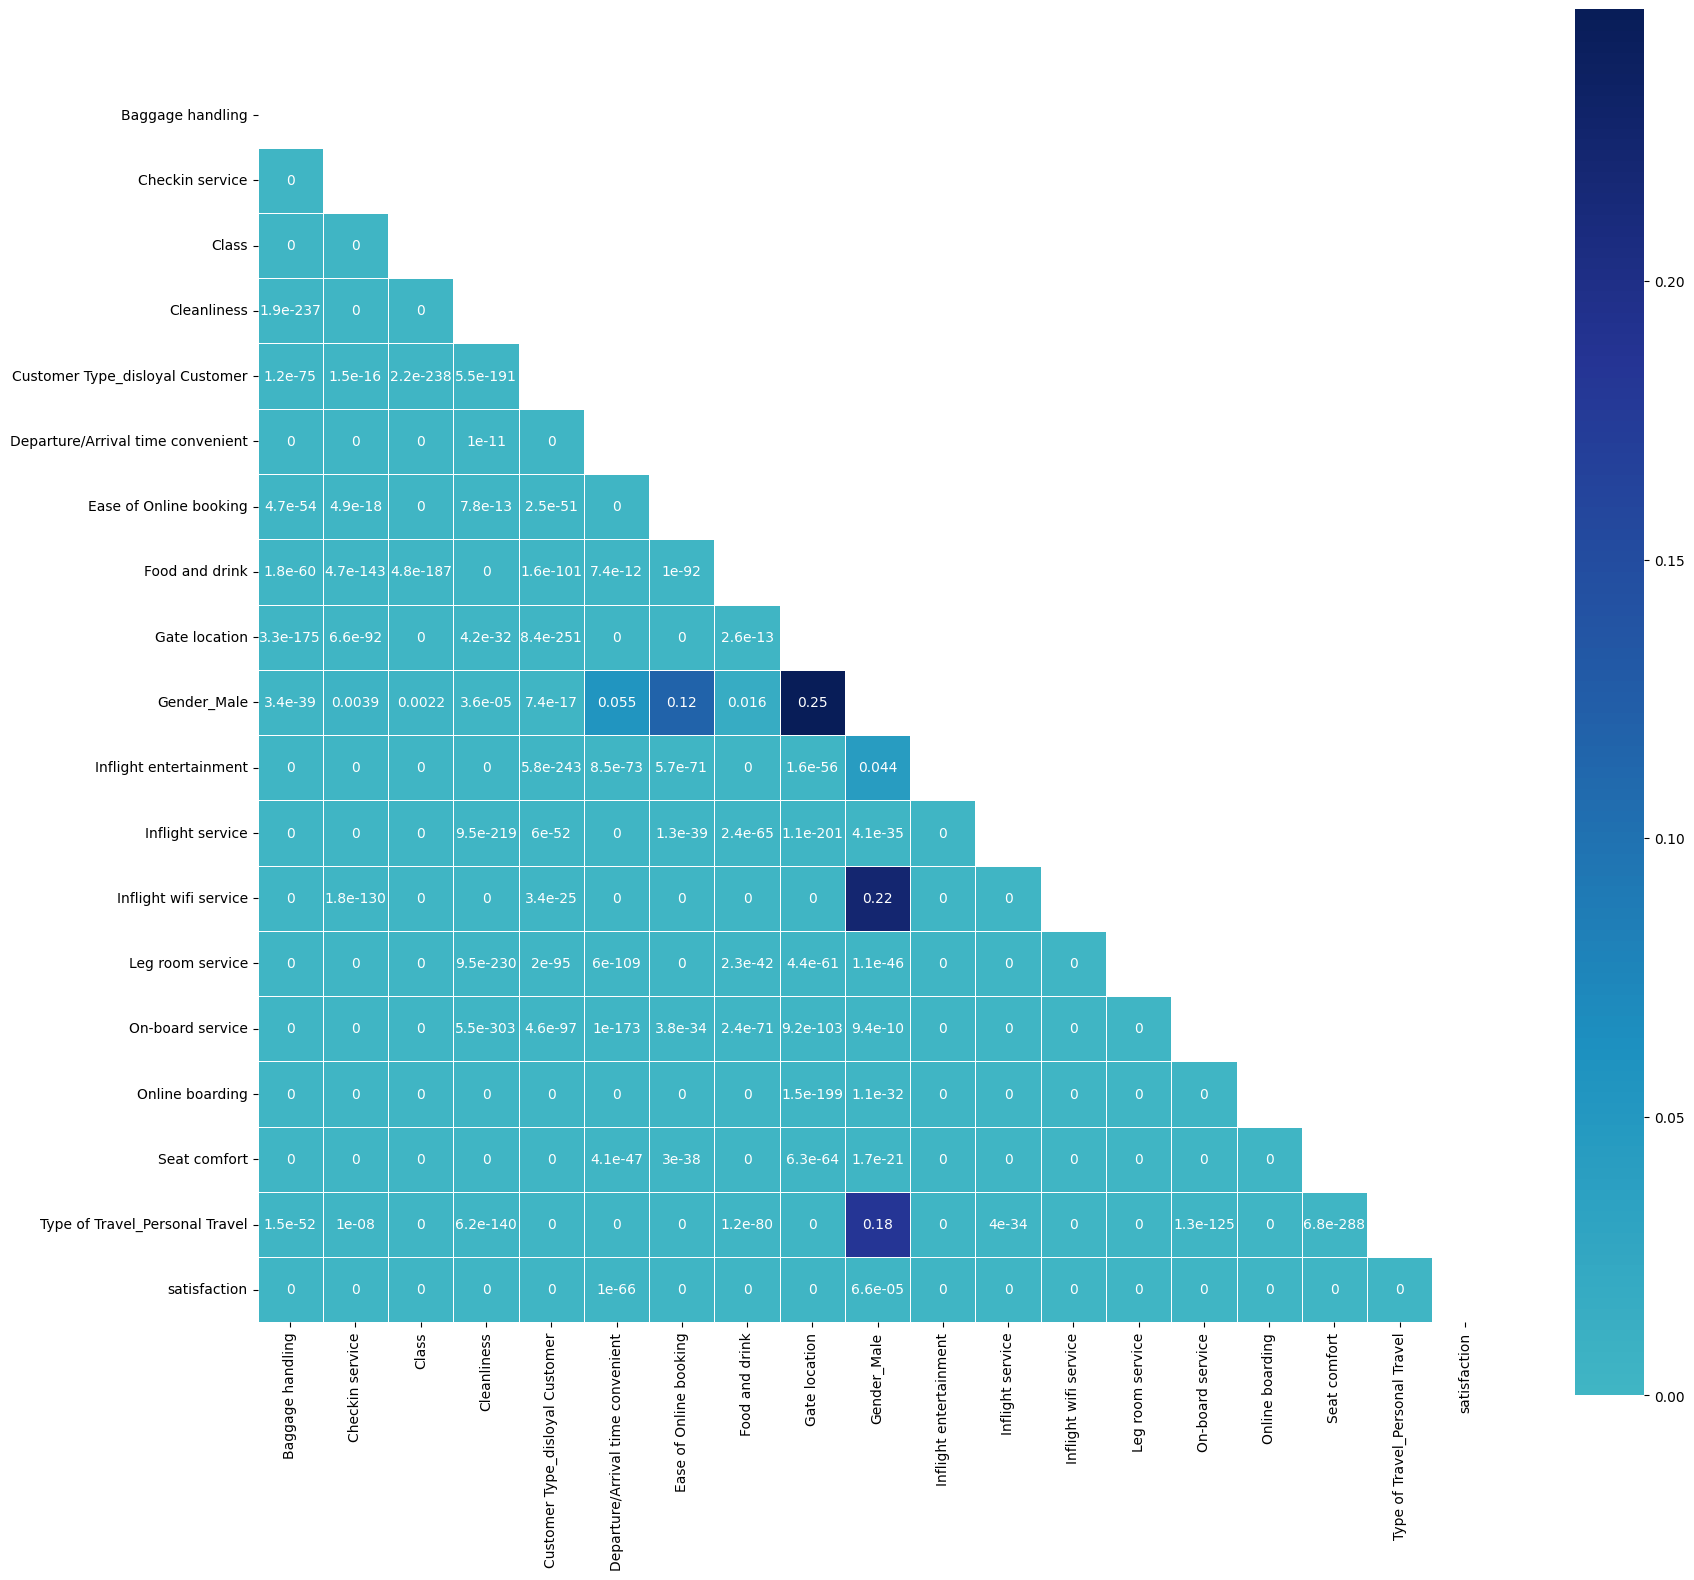

In [ ]:
chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2',
                                                       'corr'])

chi_test_output = chi_test_output.pivot(index='var1', columns='var2', values='corr')
chi_test_output =  chi_test_output.rename_axis(None, axis=1)
chi_test_output =  chi_test_output.rename_axis(None, axis=0)

# Generate a mask for the upper triangle
mask = np.zeros_like(chi_test_output, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(chi_test_output, annot = True, mask=mask, cmap="YlGnBu", center=0,
           square=True, linewidths=.5)


### Binning

In [ ]:
binning_vars = ['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']

train_df_satisfied = train_df[train_df[dec_class] == 1]
train_df_not_satisfied = train_df[train_df[dec_class] == 0]

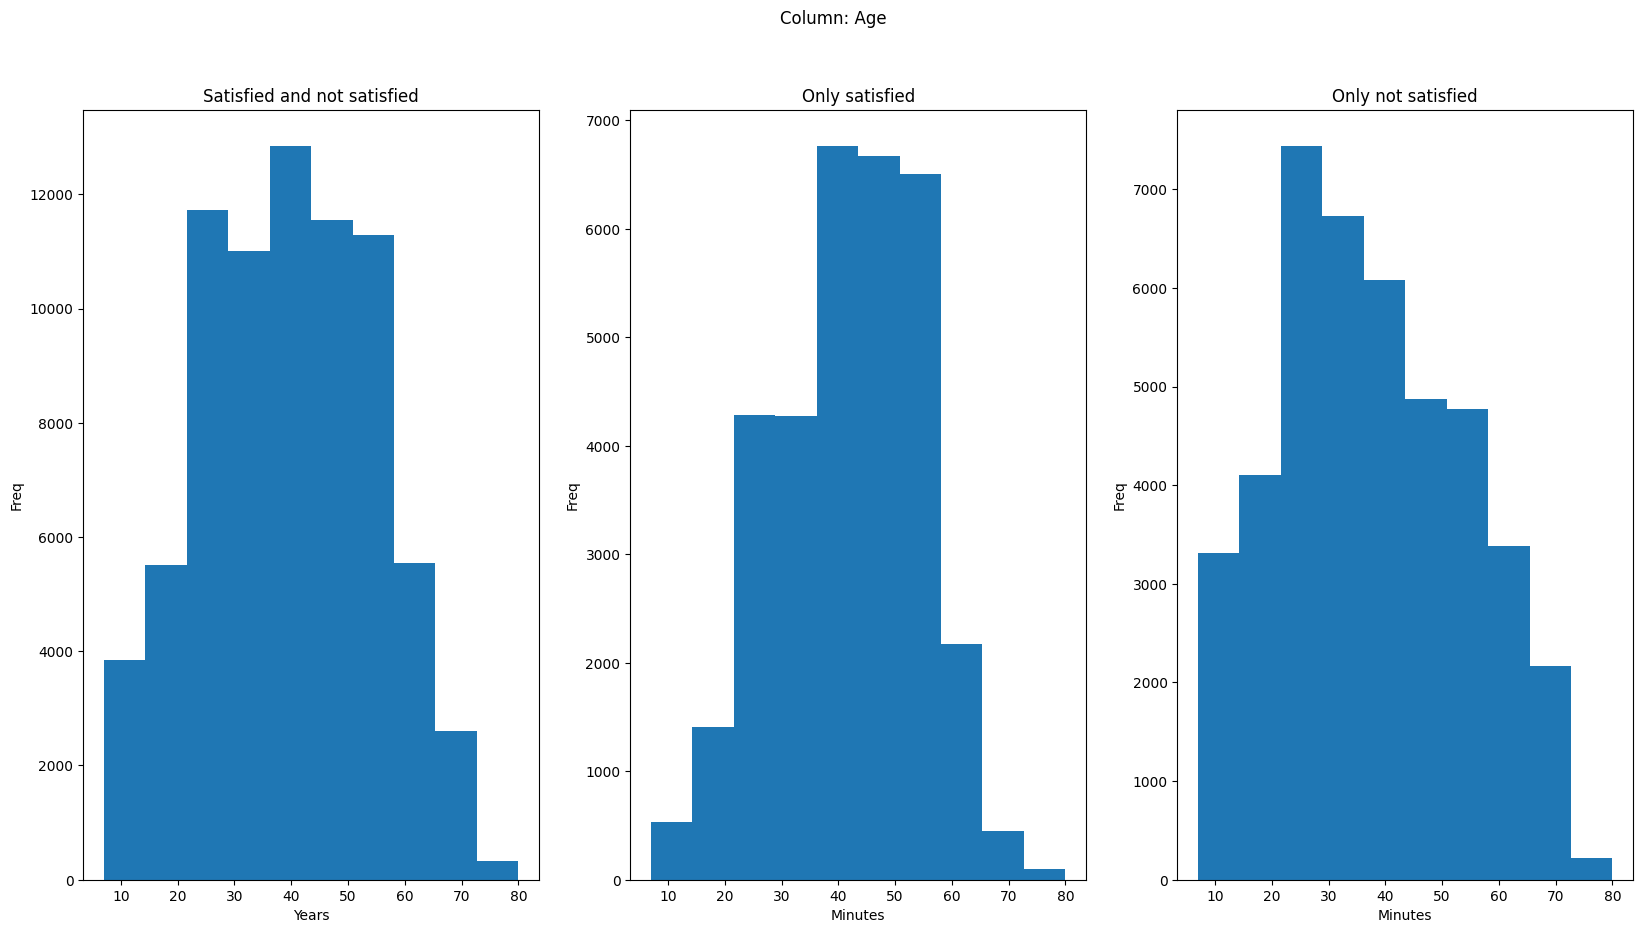

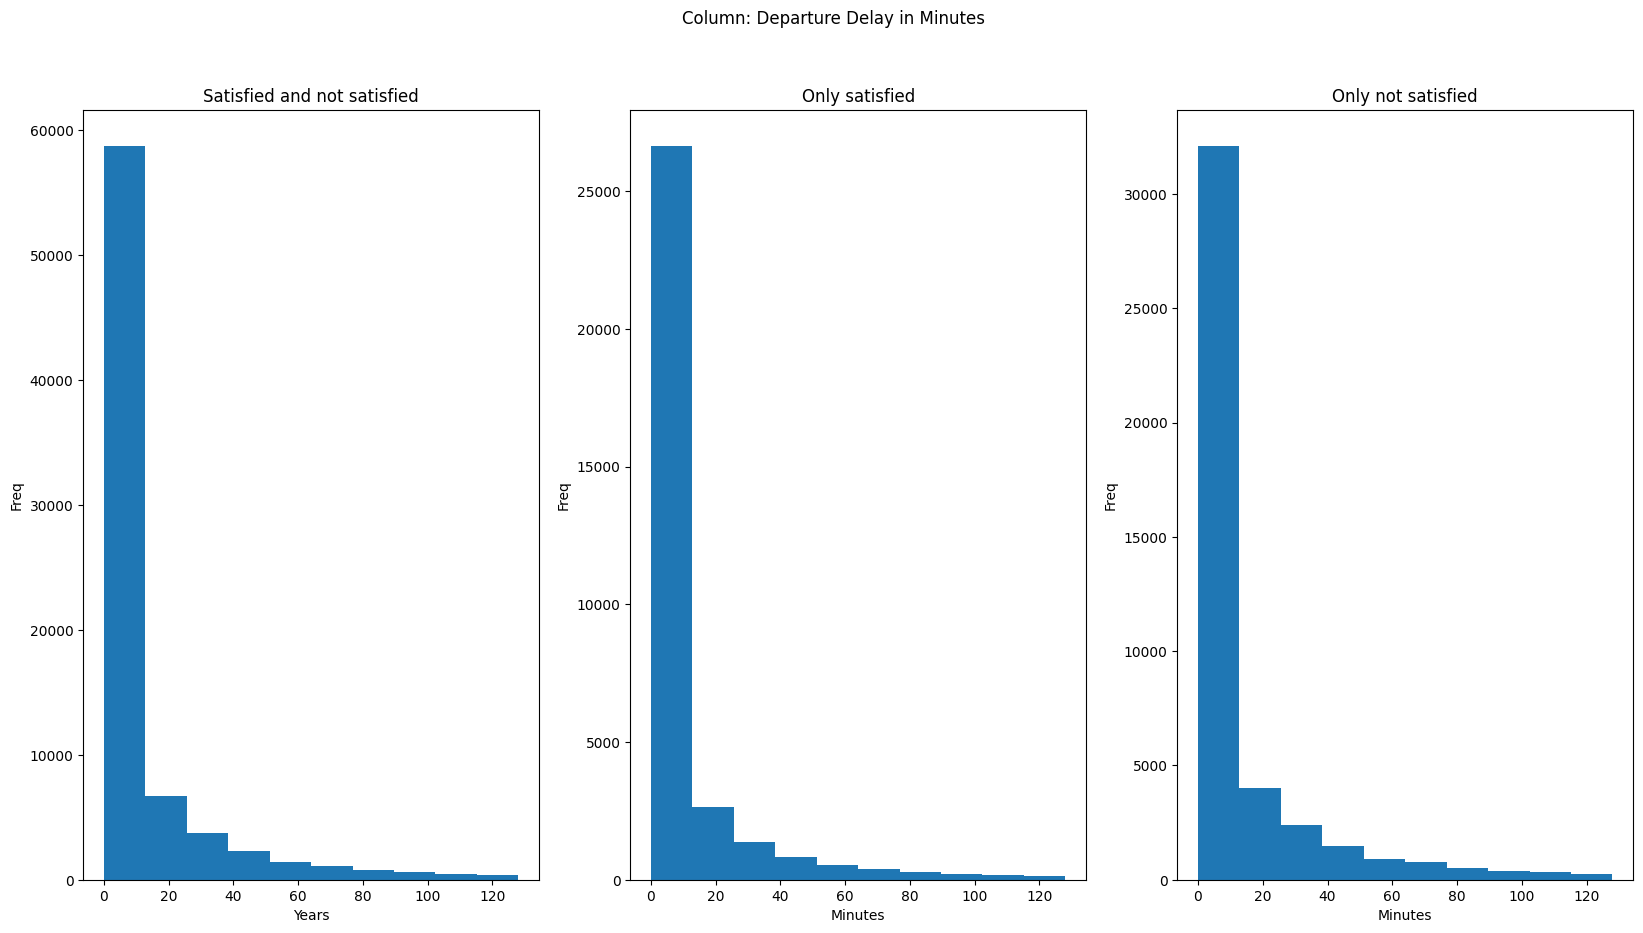

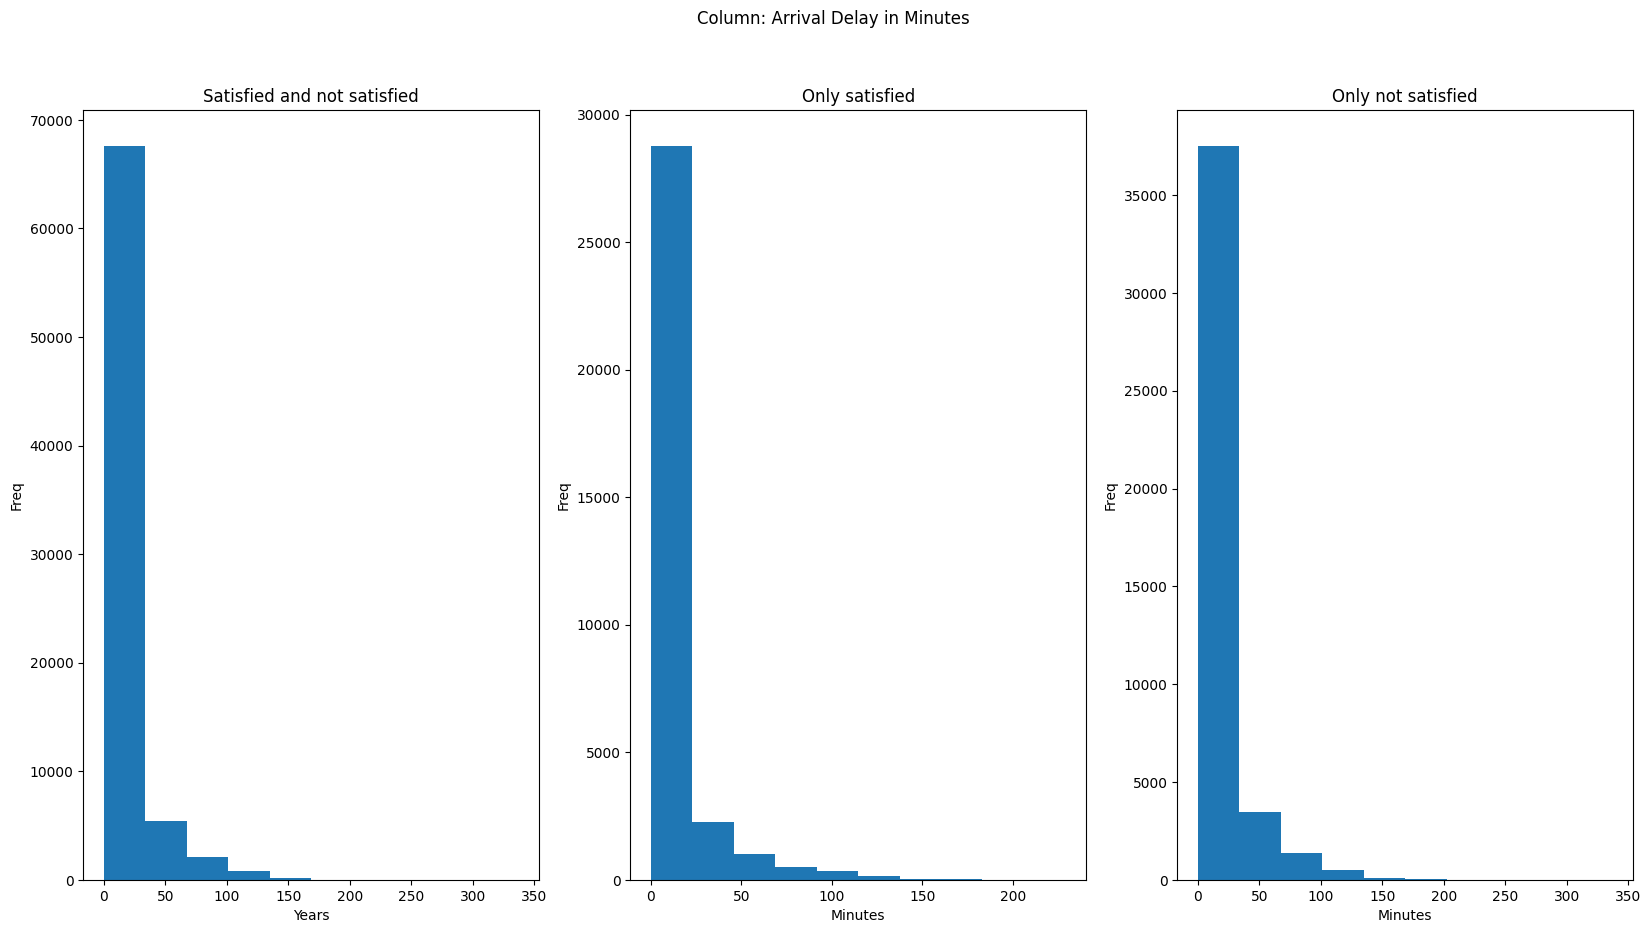

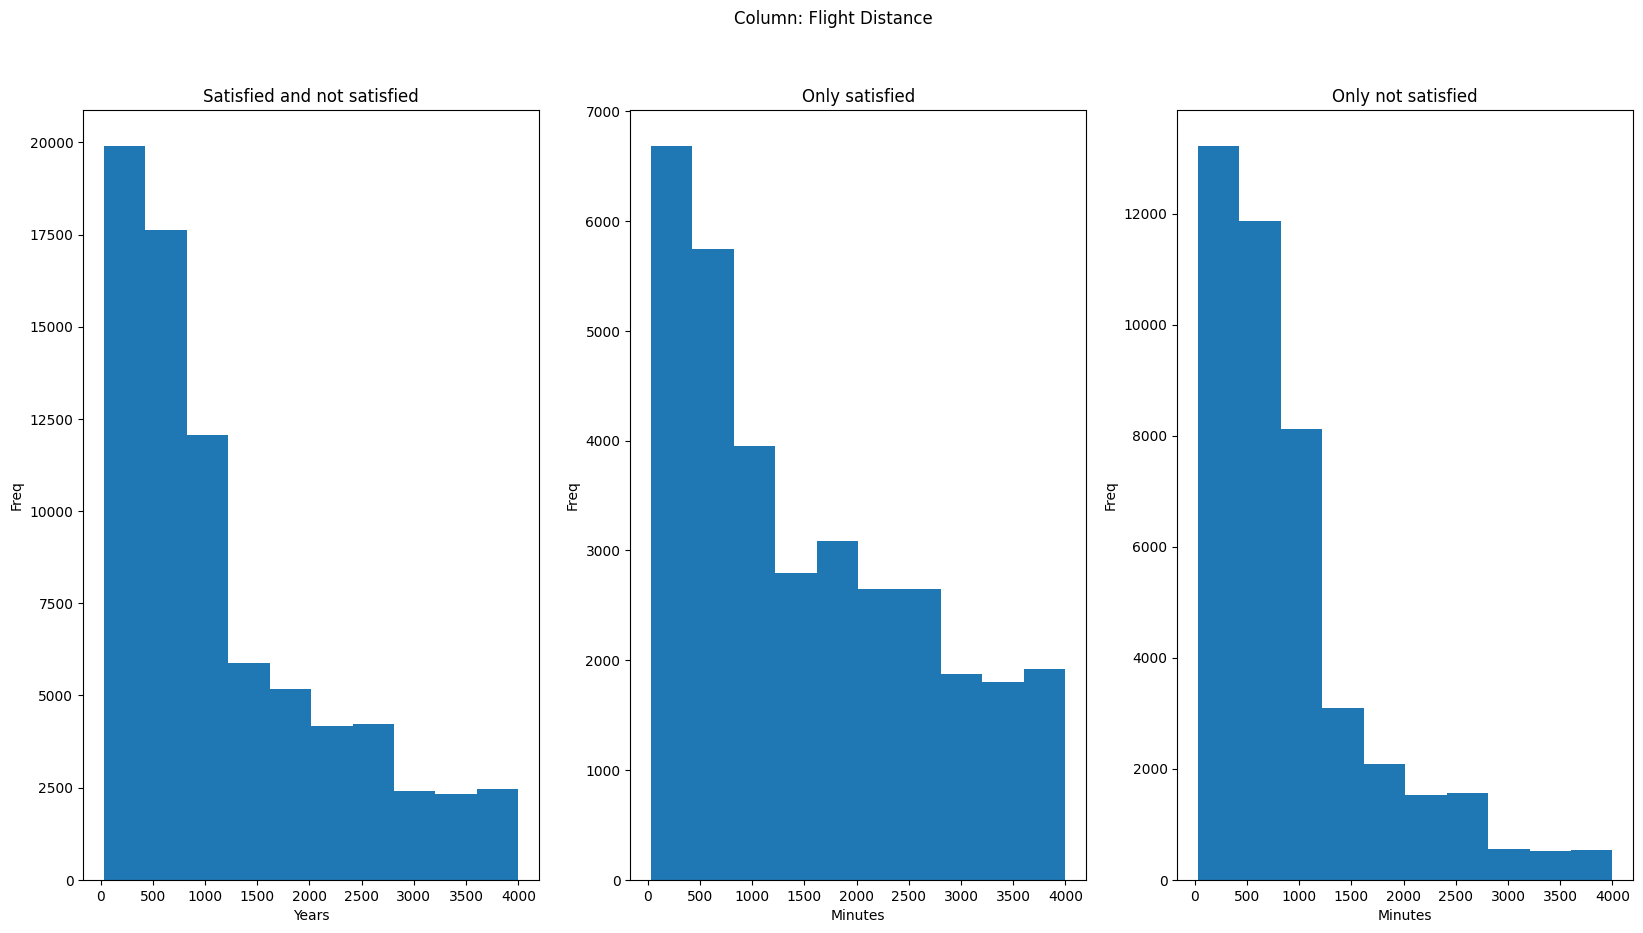

In [ ]:
for col in binning_vars:
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  fig.set_figwidth(20)
  fig.suptitle(f'Column: {col}')

  ax1.set_title('Satisfied and not satisfied')
  ax1.set(xlabel='Years', ylabel='Freq')
  ax1.hist(train_df[col])

  ax2.set_title('Only satisfied')
  ax2.set(xlabel='Minutes', ylabel='Freq')
  ax2.hist(train_df_satisfied[col])

  ax3.set_title('Only not satisfied')
  ax3.set(xlabel='Minutes', ylabel='Freq')
  ax3.hist(train_df_not_satisfied[col])

  plt.show()

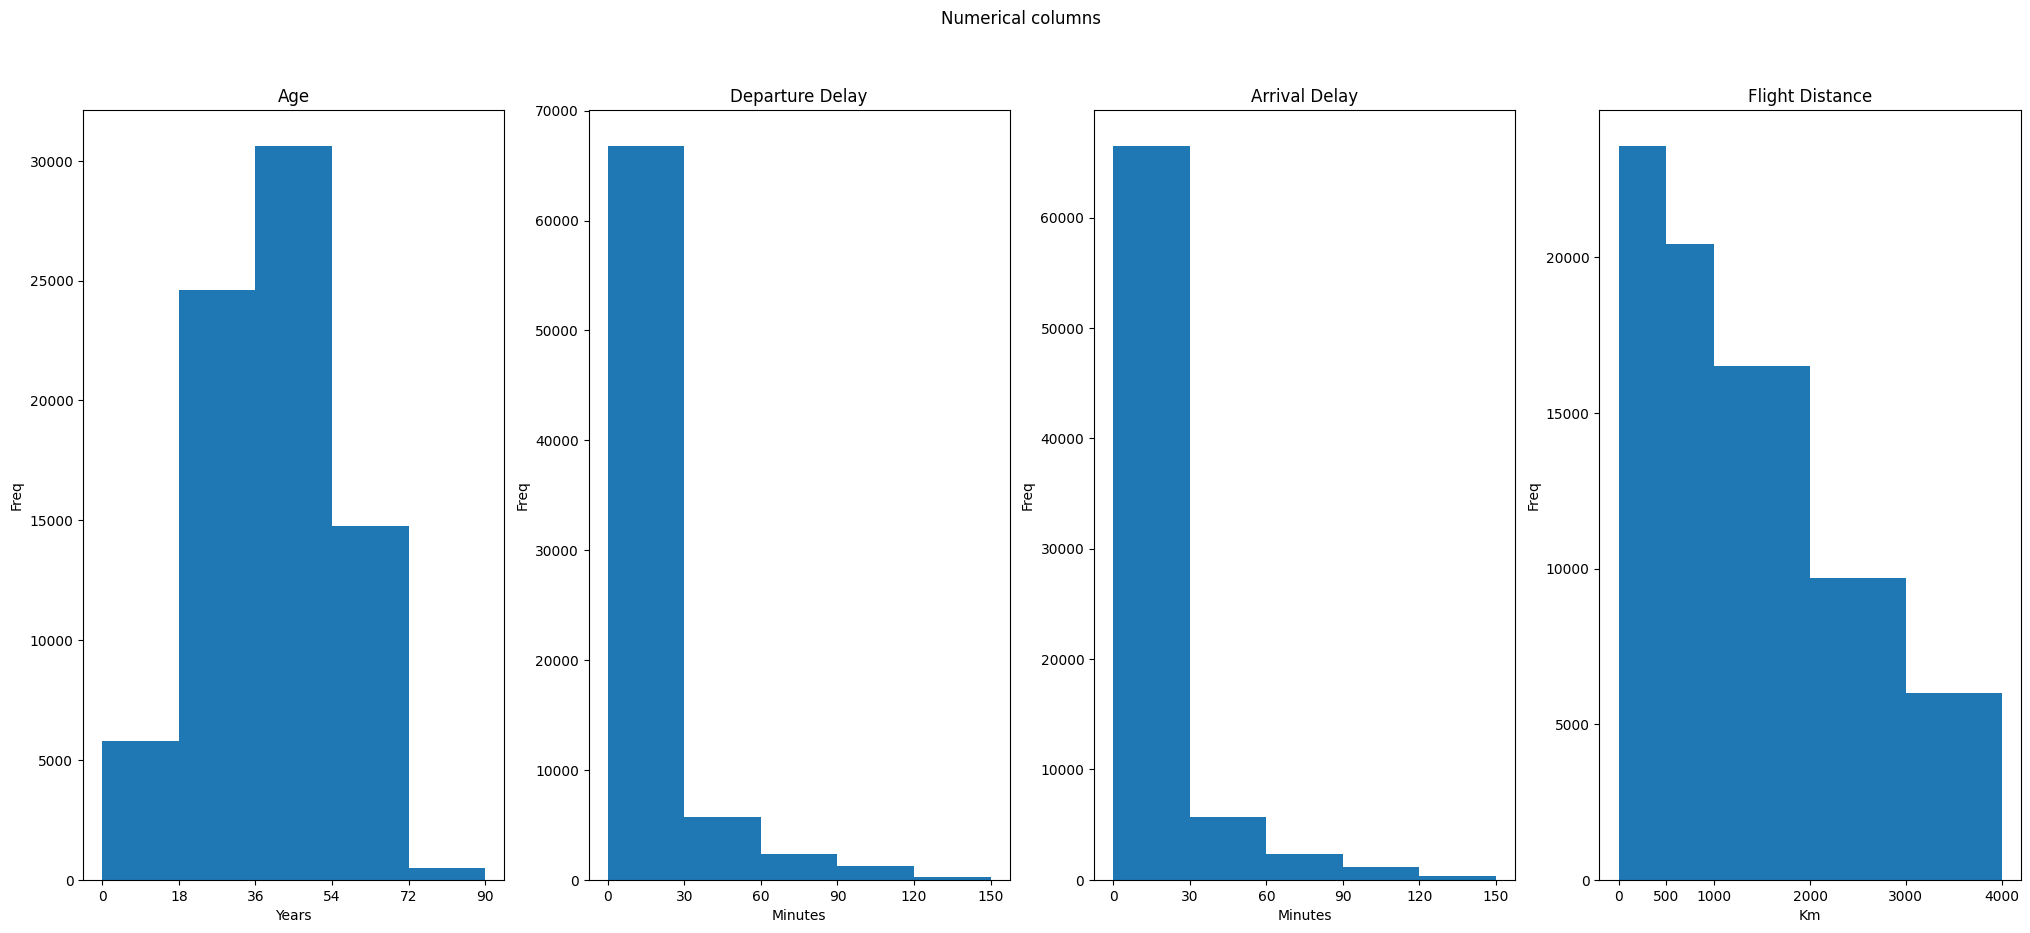

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

fig.set_figwidth(25)
fig.suptitle('Numerical columns')

bins_age = [0,18,36,54,72,90]
bins = bins_age
ax1.set_title('Age')
ax1.set(xlabel='Years', ylabel='Freq')
ax1.hist(train_df['Age'], bins=bins)
ax1.set(xticks=bins, xticklabels=bins)

bins_departure = [0,30,60,90, 120, 150]
bins = bins_departure
ax2.set_title('Departure Delay')
ax2.set(xlabel='Minutes', ylabel='Freq')
ax2.hist(train_df['Departure Delay in Minutes'],bins=bins)
ax2.set(xticks=bins, xticklabels=bins)

bins_arrival = [0,30,60,90,120,150]
bins = bins_arrival
ax3.set_title('Arrival Delay')
ax3.set(xlabel='Minutes', ylabel='Freq')
ax3.hist(train_df['Arrival Delay in Minutes'],bins=bins)
ax3.set(xticks=bins, xticklabels=bins)

bins_distance = [0,500, 1000, 2000, 3000, 4000]
bins = bins_distance
ax4.set_title('Flight Distance')
ax4.set(xlabel='Km', ylabel='Freq')
ax4.hist(train_df['Flight Distance'], bins=bins)
ax4.set(xticks=bins, xticklabels=bins)

plt.show()

In [ ]:
# def dist_binning(column: str):
#     # 4 bins
#     boundary = math.ceil((train_df[column].max()- train_df[column].min())/4)

#     print(f'{column} boundary to split: ', boundary)

#     bins_means = [math.ceil(train_df[(train_df[column] >= boundary*i) & (train_df[column] < boundary*(i+1))][column].mean()) for i in range(4)]
#     print('Bin means: ', bins_means)

#     def binnign_method(age) -> int:

#         if np.isnan(age):
#             return np.nan

#         if age < boundary:
#             return bins_means[0]

#         if age < 2*boundary:
#             return bins_means[1]

#         if age < 3*boundary:
#             return bins_means[2]

#         if age < 4*boundary:
#             return bins_means[3]

#     print(f'{column} before binning: ', train_df[column].head(10))
#     train_df[column] = train_df[column].map(binnign_method)
#     validation_df[column] = validation_df[column].map(binnign_method)
#     print(f'{column} After binning: ', train_df[column].head(10))


In [ ]:
def dist_binning(column: str, bins):
    print(f'Bns for {column} = {bins}')

    def binning_method(age) -> int:
      for index, boundary in enumerate(bins[1:]):
          if age < boundary:
              return index

      if np.isnan(age):
          return np.nan
      return(len(bins))

    print(f'{column} before binning:\n', train_df[column].head(10))
    train_df[column] = train_df[column].map(binning_method)
    validation_df[column] = validation_df[column].map(binning_method)
    test_df[column] = test_df[column].map(binning_method)
    print(f'{column} after binning:\n', train_df[column].head(10))


#### Age

In [ ]:
dist_binning(column='Age', bins=bins_age)

Bns for Age = [0, 18, 36, 54, 72, 90]
Age before binning:
 0    57
1    48
2    59
3    65
4    52
5    51
6    66
7    71
8    35
9    25
Name: Age, dtype: int64
Age after binning:
 0    3
1    2
2    3
3    3
4    2
5    2
6    3
7    3
8    1
9    1
Name: Age, dtype: int64


#### Departure Delay

In [ ]:
dist_binning(column='Departure Delay in Minutes', bins=bins_departure)

Bns for Departure Delay in Minutes = [0, 30, 60, 90, 120, 150]
Departure Delay in Minutes before binning:
 0     7
1    33
2     3
3     2
4     0
5     0
6     0
7     0
8     0
9     0
Name: Departure Delay in Minutes, dtype: int64
Departure Delay in Minutes after binning:
 0    0
1    1
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: Departure Delay in Minutes, dtype: int64


#### Arrival Delay

In [ ]:
dist_binning(column='Arrival Delay in Minutes', bins=bins_arrival)

Bns for Arrival Delay in Minutes = [0, 30, 60, 90, 120, 150]
Arrival Delay in Minutes before binning:
 0    11.0
1    30.0
2     0.0
3    37.0
4     0.0
5     0.0
6     1.0
7     0.0
8     0.0
9     0.0
Name: Arrival Delay in Minutes, dtype: float64
Arrival Delay in Minutes after binning:
 0    0.0
1    1.0
2    0.0
3    1.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: Arrival Delay in Minutes, dtype: float64


#### Flight Distance

In [ ]:
dist_binning(column='Flight Distance', bins=bins_distance)

Bns for Flight Distance = [0, 500, 1000, 2000, 3000, 4000]
Flight Distance before binning:
 0     109
1     545
2    1009
3    2486
4    3897
5     432
6     545
7     259
8    1733
9     546
Name: Flight Distance, dtype: int64
Flight Distance after binning:
 0    0
1    1
2    2
3    3
4    4
5    0
6    1
7    0
8    2
9    1
Name: Flight Distance, dtype: int64


In [ ]:
train_df.describe()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,76226.000000,76226.000000,76226.000000,76226.000000,76226.000000,76226.000000,76226.000000,76226.000000,76226.000000,76226.000000,76226.000000,76226.000000,76226.000000,76226.000000,76226.000000,76226.000000,76226.000000,76226.000000,76002.000000,76226.000000
mean,1.731968,1.030055,1.398316,2.729016,3.057841,2.757406,2.972450,3.204760,3.252184,3.440637,3.360218,3.389172,3.345512,3.629890,3.305670,3.650460,3.285769,0.196626,0.204968,0.434865
std,0.879256,0.963119,1.259362,1.326910,1.525298,1.397275,1.276711,1.328439,1.348917,1.319411,1.332507,1.284794,1.316880,1.180171,1.263416,1.170204,1.311723,0.594266,0.631796,0.495742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,0.000000,0.000000,1.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,6.000000,1.000000


### Missing Values

In [ ]:
# sns.heatmap(train_df.isnull(), cbar=False)
print(train_df.columns[train_df.isnull().any()])
columns = train_df.columns[train_df.isnull().any()]
train_df[columns] = train_df[columns].fillna(train_df[columns].median())
print(train_df.columns[train_df.isnull().any()])

Index(['Arrival Delay in Minutes'], dtype='object')
Index([], dtype='object')


In [ ]:
# sns.heatmap(validation_df.isnull(), cbar=False)
print(validation_df.columns[validation_df.isnull().any()])
columns = validation_df.columns[validation_df.isnull().any()]

#substituindo pela mediana do conjunto de teste
validation_df[columns] = validation_df[columns].fillna(train_df[columns].median())
validation_df.columns[validation_df.isnull().any()]

Index(['Arrival Delay in Minutes'], dtype='object')


Index([], dtype='object')

In [ ]:
# sns.heatmap(test_df.isnull(), cbar=False)
print(test_df.columns[test_df.isnull().any()])
columns = test_df.columns[test_df.isnull().any()]

#substituindo pela mediana do conjunto de teste
test_df[columns] = test_df[columns].fillna(train_df[columns].median())
test_df.columns[test_df.isnull().any()]

Index(['Arrival Delay in Minutes'], dtype='object')


Index([], dtype='object')

### Min Max Scaling

In [ ]:
columns = ['Age', 'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

scaler = MinMaxScaler()
f_scaler=scaler.fit(train_df[columns])

# Train
train_df[columns] = f_scaler.transform(train_df[columns])

# Validation
validation_df[columns] = f_scaler.transform(validation_df[columns])

# Test
test_df[columns] = f_scaler.transform(test_df[columns])

### OverSampling

In [ ]:
def overSampling(x, y):
  ros = RandomOverSampler(
    sampling_strategy='auto',
    random_state=0,
  )
  return ros.fit_resample(x,y)

def printClassDistributionRate(y):
  print('total: ',len(y))
  print('satisfied: ', len(y[y['satisfaction'] == 1]), ' not satisfied: ', len(y[y['satisfaction'] != 1]))
  print('satisfied: {:.2f}%'.format(len(y[y['satisfaction'] == 1])/len(y) * 100), ' not satisfied: {:.2f}%'.format(len(y[y['satisfaction'] != 1])/len(y) * 100), '\n')

In [ ]:
x_train_df = train_df.drop(columns='satisfaction')
y_train_df = train_df[['satisfaction']]

printClassDistributionRate(y_train_df)

x_train_df, y_train_df = overSampling(x_train_df, y_train_df )

printClassDistributionRate(y_train_df)

total:  76226
satisfied:  33148  not satisfied:  43078
satisfied: 43.49%  not satisfied: 56.51% 

total:  86156
satisfied:  43078  not satisfied:  43078
satisfied: 50.00%  not satisfied: 50.00% 



In [ ]:
x_validation_df = validation_df.drop(columns='satisfaction')
y_validation_df = validation_df[['satisfaction']]

printClassDistributionRate(y_validation_df)

x_validation_df, y_validation_df = overSampling(x_validation_df, y_validation_df )

printClassDistributionRate(y_validation_df)

total:  25976
satisfied:  11256  not satisfied:  14720
satisfied: 43.33%  not satisfied: 56.67% 

total:  29440
satisfied:  14720  not satisfied:  14720
satisfied: 50.00%  not satisfied: 50.00% 



# Experimento com Modelos

In [ ]:
# X_train, _, y_train, _ = train_test_split(x_train_df, y_train_df, test_size=0.90, stratify=y_train_df['satisfaction'])
# X_valid, _, y_valid, _ = train_test_split(x_validation_df, y_validation_df, test_size=0.90, stratify=y_validation_df['satisfaction'])
# X_test, _, y_test, _ = train_test_split(test_df.drop(columns='satisfaction'), test_df[['satisfaction']], test_size = 0.9, stratify=test_df[['satisfaction']]['satisfaction'])


X_train, y_train = x_train_df, y_train_df
X_valid, y_valid = x_validation_df, y_validation_df
X_test, y_test = test_df.drop(columns='satisfaction'), test_df[['satisfaction']]

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((86156, 22), (86156, 1), (29440, 22), (29440, 1), (25976, 22), (25976, 1))

In [ ]:
def plot_confusion(y_true, y_pred, title):
  disp = ConfusionMatrixDisplay.from_predictions(
  y_true,
  y_pred,
  cmap=plt.cm.Blues,
  normalize='pred',
  display_labels=['Not satisfied', 'Satisfied'],
  values_format='0.4g',
  )
  disp.ax_.set_title(title)
  disp.ax_.grid(False)
  plt.show()

def cm(label_test, predicted_test, class_labels, title, normalize='pred'):
  matrix = confusion_matrix(label_test, predicted_test, normalize=normalize)
  disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = class_labels)
  # disp.ax_.set_title(title)
  fig, ax = plt.subplots(figsize=(10,10))
  disp.plot(ax = ax)
  plt.show()

def kscurve(label_test, predicted_test, title):
  plot_ks_statistic(label_test, predicted_test, title=title)
  plt.show()

def plotRocCurve(label_test, predicted_test, title):
  fpr, tpr, _ = roc_curve(label_test, predicted_test)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.suptitle('Receiver Operating Characteristic (ROC) Curve')
  plt.title(title)
  plt.legend(loc='lower right')
  plt.show()



In [ ]:
BATCH_SIZE = 128
EPOCHS = 20000

## MLP - Keras

In [ ]:
class MPL():
  def __init__(self, in_shape, out_shape, hidden_layers, activation, dropout, optmizer, lr, regularization, patience) -> None:
    self.model = Sequential()

    self.model.add(keras.Input(shape=in_shape))
    for layer in hidden_layers:
      self.model.add(Dense(layer, activation=activation, activity_regularizer=regularizers.L2(regularization)))
      self.model.add(Dropout(dropout))


    self.model.add(Dense(out_shape, activation=activation))

    self.model.summary()

    self.early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0)

    self.opt = optmizer(learning_rate=lr)

  def __del__(self):
    del self.model

  def train(self, X_train, y_train, X_validation, y_validation, batch_size, epochs):
    self.model.compile(loss="sparse_categorical_crossentropy", optimizer=self.opt, metrics=['accuracy'])
    return self.model.fit(X_train, y_train, validation_data = (X_validation, y_validation), batch_size = batch_size, epochs = epochs, shuffle = True, callbacks=[self.early_stop_callback], verbose=0)

  def evaluate(self, X, y):
    loss, accuracy = self.model.evaluate(X, y)
    print('Loss:', loss)
    print('Accuracy:', accuracy)
    return loss, accuracy

  def predict(self, x):
    return self.model.predict(x)

In [ ]:
def plot_train_history(history):
  pd.DataFrame(history.history).plot()
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

PARAMETROS: F.Act.: softmax; Layers: [10, 5]; LR: 0.1; Dropout: 0; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9290 - loss: 0.2946
Loss: 0.2883771061897278
Accuracy: 0.9307065010070801
SCORES: acc: 0.9307065010070801, loss: 0.2883771061897278

PARAMETROS: F.Act.: softmax; Layers: [10, 5]; LR: 0.1; Dropout: 0.1; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9254 - loss: 0.3269
Loss: 0.3190096616744995
Accuracy: 0.9256114363670349
SCORES: acc: 0.9256114363670349, loss: 0.3190096616744995

PARAMETROS: F.Act.: softmax; Layers: [10, 5]; LR: 0.01; Dropout: 0; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9324 - loss: 0.2838
Loss: 0.27682486176490784
Accuracy: 0.93410325050354
SCORES: acc: 0.93410325050354, loss: 0.27682486176490784

PARAMETROS: F.Act.: softmax; Layers: [10, 5]; LR: 0.01; Dropout: 0.1; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9304 - loss: 0.3237
Loss: 0.315865695476532
Accuracy: 0.9317255616188049
SCORES: acc: 0.9317255616188049, loss: 0.315865695476532

PARAMETROS: F.Act.: softmax; Layers: [50, 25, 10]; LR: 0.1; Dropout: 0; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,707 (10.57 KB)

 Trainable params: 2,707 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9403 - loss: 0.2268
Loss: 0.21830202639102936
Accuracy: 0.942255437374115
SCORES: acc: 0.942255437374115, loss: 0.21830202639102936

PARAMETROS: F.Act.: softmax; Layers: [50, 25, 10]; LR: 0.1; Dropout: 0.1; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,707 (10.57 KB)

 Trainable params: 2,707 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9210 - loss: 0.3069
Loss: 0.2968581020832062
Accuracy: 0.921875
SCORES: acc: 0.921875, loss: 0.2968581020832062

PARAMETROS: F.Act.: softmax; Layers: [50, 25, 10]; LR: 0.01; Dropout: 0; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,707 (10.57 KB)

 Trainable params: 2,707 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9447 - loss: 0.1940
Loss: 0.1853988617658615
Accuracy: 0.94870924949646
SCORES: acc: 0.94870924949646, loss: 0.1853988617658615

PARAMETROS: F.Act.: softmax; Layers: [50, 25, 10]; LR: 0.01; Dropout: 0.1; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,707 (10.57 KB)

 Trainable params: 2,707 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9419 - loss: 0.2244
Loss: 0.21362800896167755
Accuracy: 0.944972813129425
SCORES: acc: 0.944972813129425, loss: 0.21362800896167755

PARAMETROS: F.Act.: softmax; Layers: [50, 50, 50]; LR: 0.1; Dropout: 0; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,352 (24.81 KB)

 Trainable params: 6,352 (24.81 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9168 - loss: 0.2811
Loss: 0.27115780115127563
Accuracy: 0.9191576242446899
SCORES: acc: 0.9191576242446899, loss: 0.27115780115127563

PARAMETROS: F.Act.: softmax; Layers: [50, 50, 50]; LR: 0.1; Dropout: 0.1; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,352 (24.81 KB)

 Trainable params: 6,352 (24.81 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9308 - loss: 0.2204
Loss: 0.2072400450706482
Accuracy: 0.9351223111152649
SCORES: acc: 0.9351223111152649, loss: 0.2072400450706482

PARAMETROS: F.Act.: softmax; Layers: [50, 50, 50]; LR: 0.01; Dropout: 0; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,352 (24.81 KB)

 Trainable params: 6,352 (24.81 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5065 - loss: 0.7123
Loss: 0.7123563885688782
Accuracy: 0.5
SCORES: acc: 0.5, loss: 0.7123563885688782

PARAMETROS: F.Act.: softmax; Layers: [50, 50, 50]; LR: 0.01; Dropout: 0.1; Reg: 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,352 (24.81 KB)

 Trainable params: 6,352 (24.81 KB)

 Non-trainable params: 0 (0.00 B)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5065 - loss: 0.7123
Loss: 0.7123592495918274
Accuracy: 0.5
SCORES: acc: 0.5, loss: 0.7123592495918274



Best model args: PARAMETROS: F.Act.: softmax; Layers: [50, 25, 10]; LR: 0.01; Dropout: 0; Reg: 0.01


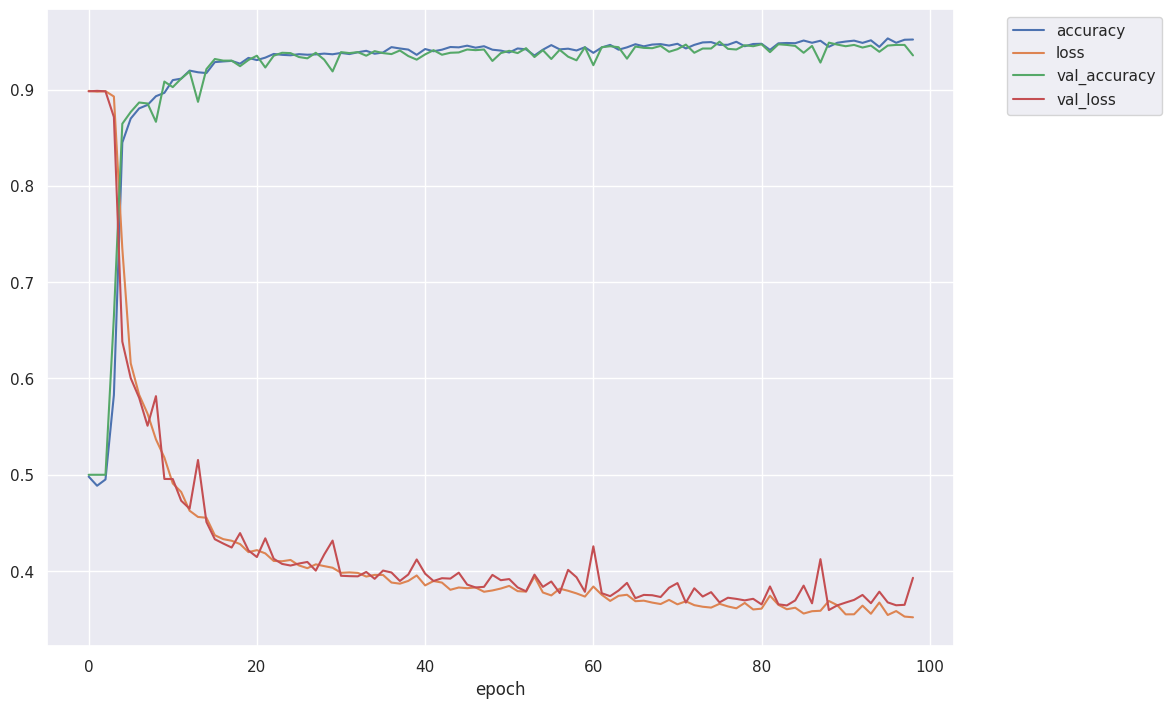

In [ ]:
def grid_search(X_t, y_t, X_v, y_v, activation_fn, hidden_layers, learning_rate, dropout, regularization):
  best_acc = 0
  best_model = None
  best_hist = None
  args = None

  for act in activation_fn:
    for hl in hidden_layers:
      for lr in learning_rate:
        for drp in dropout:
          for reg in regularization:
            print(f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}')
            tf.keras.backend.clear_session()
            model = MPL(in_shape=(22,), out_shape=2, hidden_layers=hl, activation=act, dropout=drp, optmizer=optimizers.Adam, lr=lr, regularization=reg, patience=10)
            history = model.train(X_t, y_t, X_v, y_v, batch_size=BATCH_SIZE, epochs=EPOCHS)
            loss, acc = model.evaluate(X_v, y_v)
            if acc > best_acc:
                best_acc = acc
                best_model = model
                best_hist = history
                args = f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}'
            print(f'SCORES: acc: {acc}, loss: {loss}\n')
            del model
            del history
  print(f"\n\nBest model args: {args}")
  return best_model, best_hist, args

X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train.values).astype('float32')
X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid.values).astype('float32')

hidden_channels = [[10, 5], [50, 25, 10], [50, 50, 50]]
# actv_fns = ['sigmoid', 'relu', 'tanh','softmax']
actv_fns = ['softmax']
learning_rates = [0.1, 0.01]
dropout = [0, 0.1]
regularization = [0.01]
# regularization = [0, 0.01]

# hidden_channels = [[10, 5]]
# actv_fns = ['softmax']
# learning_rates = [0.01]
# dropout = [0]
# regularization = [0.01]

best_model, best_hist, args = grid_search(X_t, y_t, X_v, y_v, actv_fns, hidden_channels, learning_rates, dropout, regularization)
plot_train_history(best_hist)

In [ ]:
best_model.evaluate(X_v, y_v)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9447 - loss: 0.1940
Loss: 0.1853988617658615
Accuracy: 0.94870924949646


(0.1853988617658615, 0.94870924949646)

In [ ]:
y_pred = best_model.predict(X_v)
y_pred_soft = special.softmax(np.array( y_pred), axis=1)

In [ ]:
kscurve(y_v, y_pred_soft, 'Best Model')

In [ ]:
plotRocCurve(y_v, y_pred_soft[:, 1], 'Best Model')

In [ ]:
y_pred_normalized = [1 if r > 0.502 else 0 for (_,r) in y_pred_soft]
plot_confusion(y_v, y_pred_normalized, 'Best Model')

## MLP - Keras c/ Optuna

In [ ]:
class MPL():
  def __init__(self, in_shape, out_shape, hidden_layers, activation, dropout, optmizer, lr, regularization, patience) -> None:
    print('Available GPUs:', tf.config.list_physical_devices('GPU'))
    self.model = Sequential()

    self.model.add(keras.Input(shape=in_shape))
    for layer in hidden_layers:
      self.model.add(Dense(layer, activation=activation, activity_regularizer=regularizers.L2(regularization)))
      self.model.add(Dropout(dropout))


    self.model.add(Dense(out_shape, activation=activation))

    self.model.summary()

    self.early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0)

    self.opt = optmizer(learning_rate=lr)

  def __del__(self):
    del self.model

  def train(self, X_train, y_train, X_validation, y_validation, batch_size, epochs):
    self.model.compile(loss="sparse_categorical_crossentropy", optimizer=self.opt, metrics=['accuracy'])
    return self.model.fit(X_train, y_train, validation_data = (X_validation, y_validation), batch_size = batch_size, epochs = epochs, shuffle = True, callbacks=[self.early_stop_callback], verbose=0)

  def evaluate(self, X, y):
    loss, accuracy = self.model.evaluate(X, y)
    print('Loss:', loss)
    print('Accuracy:', accuracy)
    return loss, accuracy

  def predict(self, x):
    return self.model.predict(x)

In [ ]:
def plot_train_history(history):
  pd.DataFrame(history.history).plot()
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

[I 2024-07-30 02:29:03,613] A new study created in memory with name: no-name-d98c0fd9-d380-43c4-903e-1a9cea70eb09


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,707 (10.57 KB)

 Trainable params: 2,707 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9586 - loss: 0.0965
Loss: 0.098014235496521
Accuracy: 0.9576766490936279


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 

[I 2024-07-30 02:32:01,673] Trial 0 finished with value: 0.098014235496521 and parameters: {'Hidden Channels': '[50, 25, 10]', 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 0 with value: 0.098014235496521.


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 25)                  │             575 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │             315 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,592 (6.22 KB)

 Trainable params: 1,592 (6.22 KB)

 Non-trainable params: 0 (0.00 B)

920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9269 - loss: 0.3298
Loss: 0.3304286599159241
Accuracy: 0.9271059632301331


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 

[I 2024-07-30 02:33:02,366] Trial 1 finished with value: 0.3304286599159241 and parameters: {'Hidden Channels': '[25, 20, 15, 10]', 'Activation Function': 'softmax', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 0 with value: 0.098014235496521.


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,707 (10.57 KB)

 Trainable params: 2,707 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5628 - loss: 0.6931
Loss: 0.6931538581848145
Accuracy: 0.5


[I 2024-07-30 02:34:02,832] Trial 2 finished with value: 0.6931538581848145 and parameters: {'Hidden Channels': '[50, 25, 10]', 'Activation Function': 'relu', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 0 with value: 0.098014235496521.


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,707 (10.57 KB)

 Trainable params: 2,707 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4372 - loss: 0.6931
Loss: 0.6931518316268921
Accuracy: 0.5


[I 2024-07-30 02:34:47,533] Trial 3 finished with value: 0.6931518316268921 and parameters: {'Hidden Channels': '[50, 25, 10]', 'Activation Function': 'tanh', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 0 with value: 0.098014235496521.


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,707 (10.57 KB)

 Trainable params: 2,707 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

920/920 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4372 - loss: 20.8581
Loss: 20.858097076416016
Accuracy: 0.5


[I 2024-07-30 02:35:29,555] Trial 4 finished with value: 20.858097076416016 and parameters: {'Hidden Channels': '[50, 25, 10]', 'Activation Function': 'tanh', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 0 with value: 0.098014235496521.


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9406 - loss: 0.1441
Loss: 0.14738059043884277
Accuracy: 0.940591037273407


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 

[I 2024-07-30 02:41:18,061] Trial 5 finished with value: 0.14738059043884277 and parameters: {'Hidden Channels': '[10, 5]', 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 0 with value: 0.098014235496521.


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,707 (10.57 KB)

 Trainable params: 2,707 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5628 - loss: 0.6931
Loss: 0.6931518316268921
Accuracy: 0.5


[I 2024-07-30 02:41:58,539] Trial 6 finished with value: 0.6931518316268921 and parameters: {'Hidden Channels': '[50, 25, 10]', 'Activation Function': 'relu', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0.01}. Best is trial 0 with value: 0.098014235496521.


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,707 (10.57 KB)

 Trainable params: 2,707 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5628 - loss: 7.1152
Loss: 7.133918762207031
Accuracy: 0.5


[I 2024-07-30 02:42:34,338] Trial 7 finished with value: 7.133918762207031 and parameters: {'Hidden Channels': '[50, 25, 10]', 'Activation Function': 'tanh', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0.01}. Best is trial 0 with value: 0.098014235496521.


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 25)                  │             575 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │             315 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,592 (6.22 KB)

 Trainable params: 1,592 (6.22 KB)

 Non-trainable params: 0 (0.00 B)

920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5628 - loss: 0.6931
Loss: 0.6931518316268921
Accuracy: 0.5


[I 2024-07-30 02:43:03,475] Trial 8 finished with value: 0.6931518316268921 and parameters: {'Hidden Channels': '[25, 20, 15, 10]', 'Activation Function': 'tanh', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 0 with value: 0.098014235496521.


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           1,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,707 (10.57 KB)

 Trainable params: 2,707 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5628 - loss: 15.5791
Loss: 15.574028968811035
Accuracy: 0.5


[I 2024-07-30 02:44:02,606] Trial 9 finished with value: 15.574028968811035 and parameters: {'Hidden Channels': '[50, 25, 10]', 'Activation Function': 'tanh', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0.01}. Best is trial 0 with value: 0.098014235496521.


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9485 - loss: 0.1231
Loss: 0.12291129678487778
Accuracy: 0.948335587978363


[I 2024-07-30 02:47:30,685] Trial 10 finished with value: 0.12291129678487778 and parameters: {'Hidden Channels': '[10, 5]', 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 0 with value: 0.098014235496521.


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9505 - loss: 0.1185
Loss: 0.11948990076780319
Accuracy: 0.9493546485900879


[I 2024-07-30 02:52:42,868] Trial 11 finished with value: 0.11948990076780319 and parameters: {'Hidden Channels': '[10, 5]', 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 0 with value: 0.098014235496521.


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9437 - loss: 0.1404
Loss: 0.1398361176252365
Accuracy: 0.9423233866691589


[I 2024-07-30 02:56:59,455] Trial 12 finished with value: 0.1398361176252365 and parameters: {'Hidden Channels': '[10, 5]', 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 0 with value: 0.098014235496521.


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │             230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297 (1.16 KB)

 Trainable params: 297 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

920/920 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9501 - loss: 0.1207
Loss: 0.1231502965092659
Accuracy: 0.948437511920929


[I 2024-07-30 03:01:29,158] Trial 13 finished with value: 0.1231502965092659 and parameters: {'Hidden Channels': '[10, 5]', 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 0 with value: 0.098014235496521.


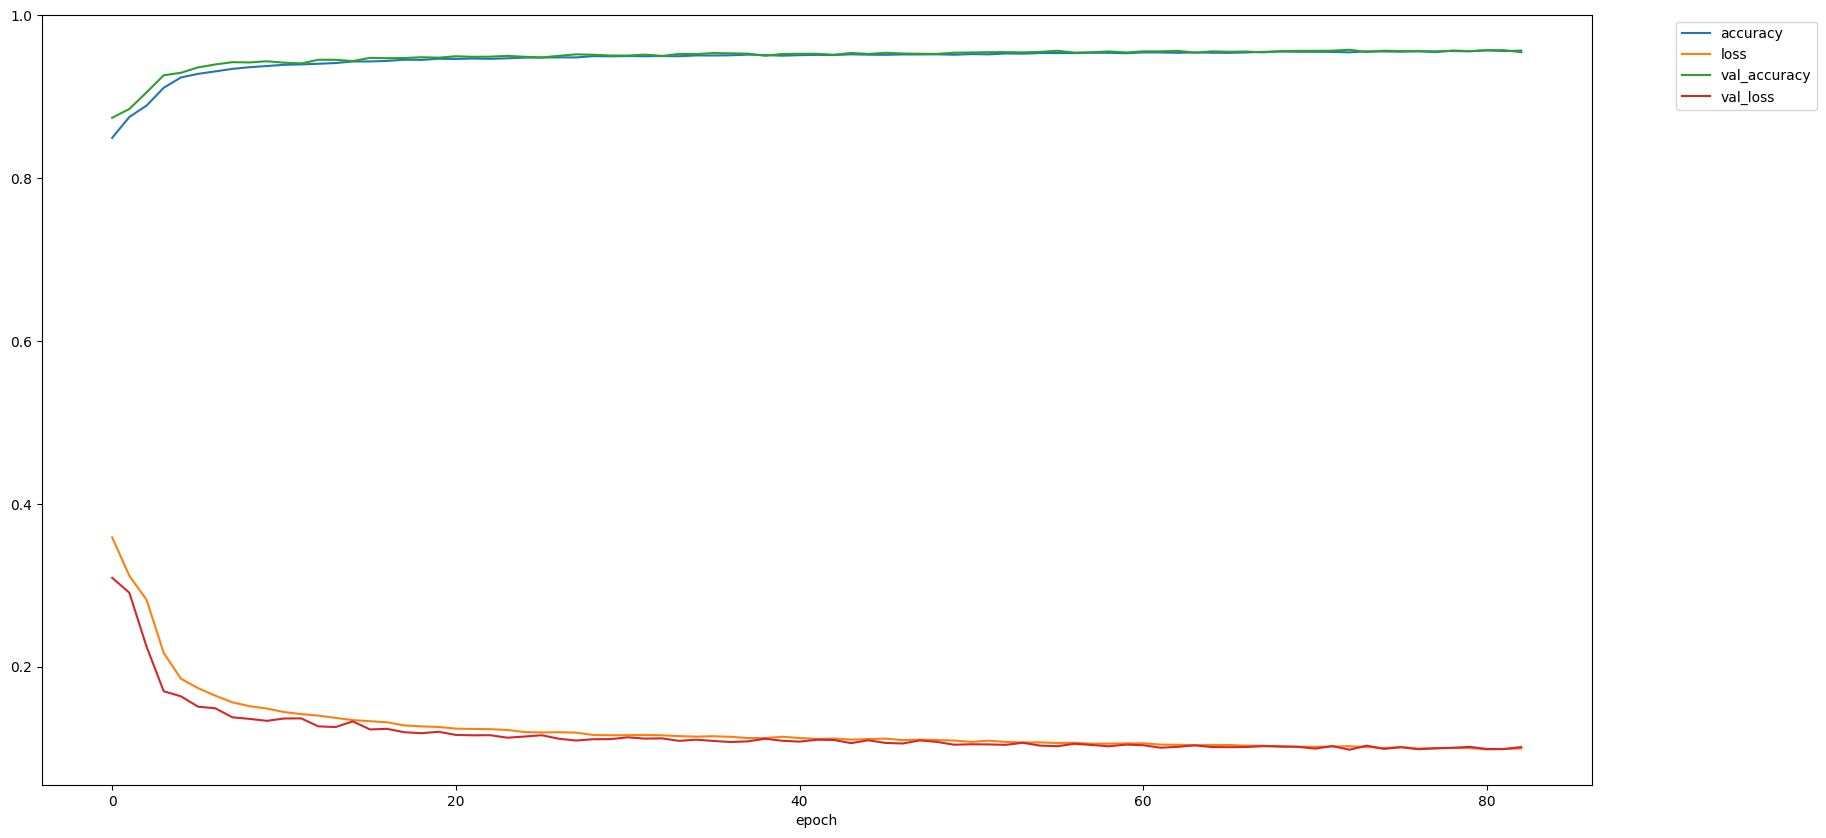

In [ ]:
#30m14s pra treinar tudo

X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train.values).astype('float32')
X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid.values).astype('float32')
X_tst, y_tst = np.asarray(X_test.values).astype('float32'), np.asarray(y_test.values).astype('float32')

def objective(trial):

  hidden_channels = ["[10, 5]",
                     "[50, 25, 10]",
                     "[25, 20, 15, 10]"]
  actv_fns = ['sigmoid', 'relu', 'tanh','softmax']
  learning_rates = [1e-2, 1e-1]
  dropout = [0, 0.1]
  regularization = [0, 1e-2]

  hl = trial.suggest_categorical('Hidden Channels', hidden_channels)
  act = trial.suggest_categorical('Activation Function', actv_fns)
  lr = trial.suggest_categorical('Learning rate', learning_rates)
  drp = trial.suggest_categorical('Dropout', dropout)
  reg = trial.suggest_categorical('Regularization', regularization)

  tf.keras.backend.clear_session()

  model = MPL(in_shape=(22,), out_shape=2, hidden_layers=eval(hl), activation=act, dropout=drp, optmizer=optimizers.Adam, lr=lr, regularization=reg, patience=10)
  history = model.train(X_t, y_t, X_v, y_v, batch_size=BATCH_SIZE, epochs=EPOCHS)
  loss, acc = model.evaluate(X_v, y_v)

  trial.set_user_attr(key="model", value=(model, history))

  return loss

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["model"])
    else:
        trial.set_user_attr(key="model", value = None)

study = opt.create_study(direction = 'minimize', pruner = opt.pruners.MedianPruner())
study.optimize(objective, n_trials=100, timeout = 30*60, callbacks=[callback])

best_model, best_hist = study.user_attrs['best_model']
plot_train_history(best_hist)

In [ ]:
study.best_params

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 



{'Hidden Channels': '[50, 25, 10]',
 'Activation Function': 'sigmoid',
 'Learning rate': 0.01,
 'Dropout': 0.1,
 'Regularization': 0}

In [ ]:
opt.visualization.plot_optimization_history(study)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 



In [ ]:
opt.visualization.plot_param_importances(study)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 



In [ ]:
opt.visualization.plot_slice(study)

### Avaliação de Desempenho

In [ ]:
best_model.evaluate(X_tst, y_tst)

812/812 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9580 - loss: 0.0965
Loss: 0.09486955404281616
Accuracy: 0.9601940512657166


(0.09486955404281616, 0.9601940512657166)

In [ ]:
y_pred = best_model.predict(X_tst)
probs = special.softmax(np.array( y_pred), axis=1)

812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


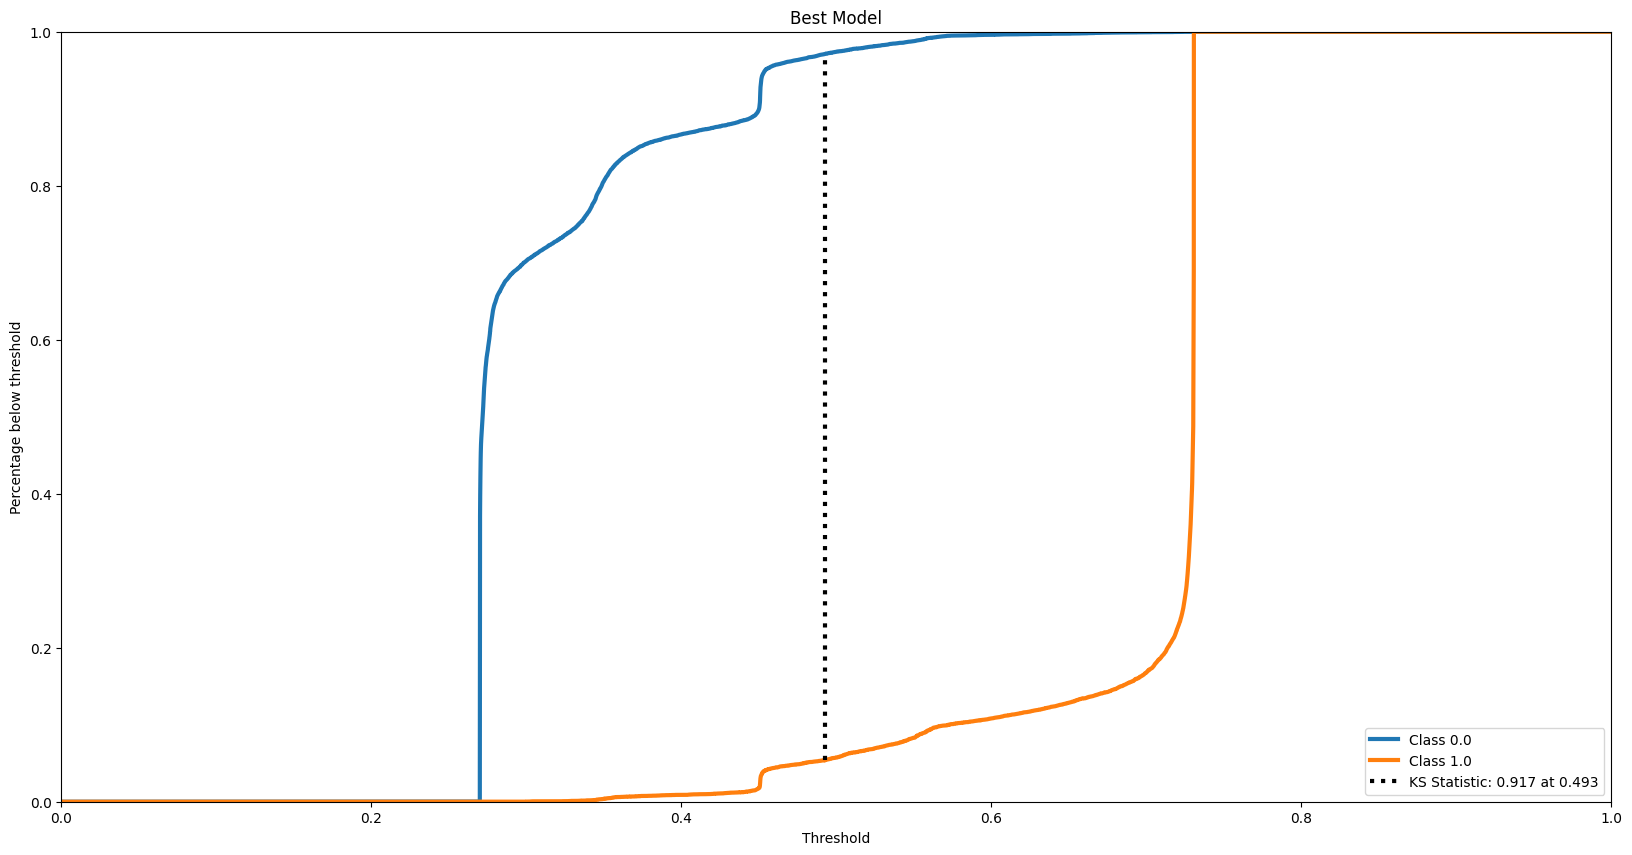

In [ ]:
kscurve(y_tst.ravel(), probs, 'Best Model')

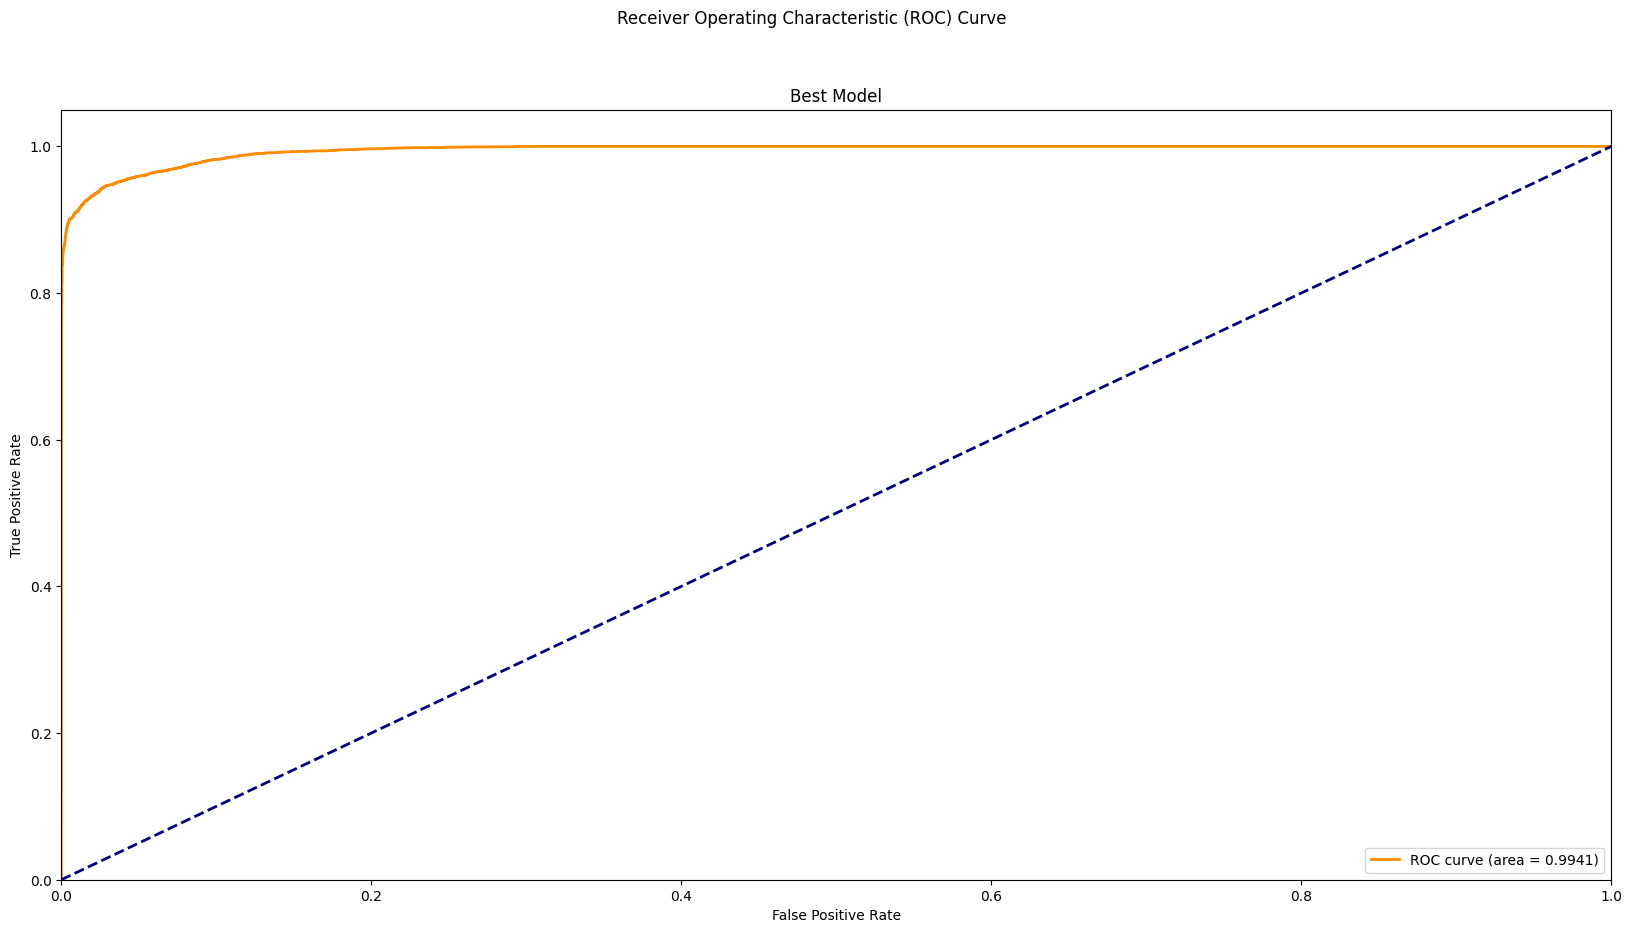

In [ ]:
plotRocCurve(y_tst, probs[:, 1], 'Best Model')

Test acc: 0.9601555281798583


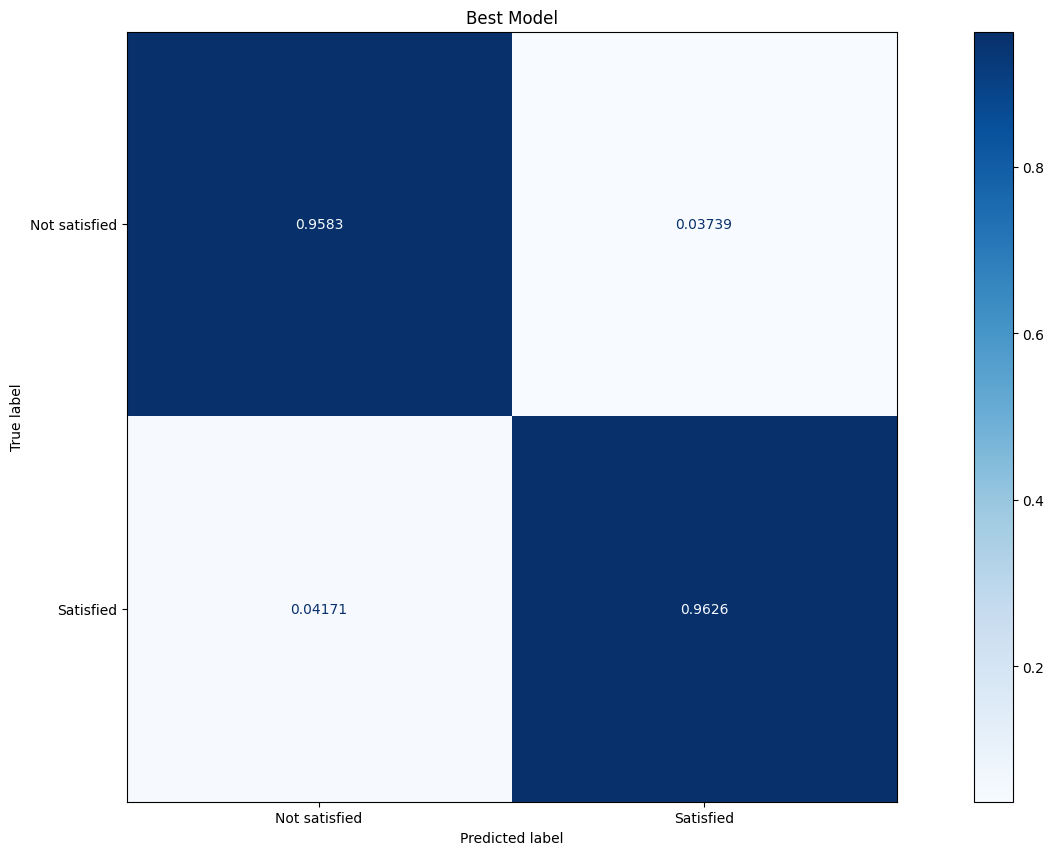

In [ ]:
y_pred_classification = probs > 0.493

print('Test acc:', (y_pred_classification[:, 1] == y_tst.ravel()).sum()/len(y_tst))
plot_confusion(y_tst, y_pred_classification[:, 1], 'Best Model')

## RF - Keras

In [ ]:
tuner = tfdf.tuner.RandomSearch(num_trials=100, trial_num_threads=4)
tuner.choice("max_depth", [16, 20, 24])

tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"])
tuner.choice("max_num_nodes", [16, 32, 64])
tuner.choice("num_trees", [150, 350])

model = tfdf.keras.RandomForestModel(tuner=tuner, num_threads=96)

X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train.values).astype('float32')
X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid.values).astype('float32')
X_tst, y_tst = np.asarray(X_test.values).astype('float32'), np.asarray(y_test.values).astype('float32')

model.compile(metrics=["accuracy"])

history = model.fit(X_t, y_t, validation_data=(X_v, y_v))

Use /tmp/tmpjr8gdw2f as temporary training directory
Reading training dataset...
Training dataset read in 0:00:05.605335. Found 86156 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(29440, shape=(), dtype=int32)
Validation dataset read in 0:00:03.439241. Found 29440 examples.
Training model...
Model trained in 0:05:05.885687
Compiling model...
Model compiled.


In [ ]:
tuning_logs = model.make_inspector().tuning_logs()

tuning_logs

,score,evaluation_time,best,max_depth,growing_strategy,max_num_nodes,num_trees
0,0.932030,12.527950,False,16,BEST_FIRST_GLOBAL,64,150
1,0.918299,30.722536,False,16,BEST_FIRST_GLOBAL,16,350
2,0.932854,59.819711,False,24,BEST_FIRST_GLOBAL,64,350
3,0.916338,67.539678,False,16,BEST_FIRST_GLOBAL,16,150
4,0.932924,97.675218,True,16,BEST_FIRST_GLOBAL,64,350
5,0.918299,116.375840,False,24,BEST_FIRST_GLOBAL,16,350
6,0.924822,126.133356,False,20,BEST_FIRST_GLOBAL,32,150
7,0.925809,150.138041,False,16,BEST_FIRST_GLOBAL,32,350
8,0.925809,174.173731,False,20,BEST_FIRST_GLOBAL,32,350
9,0.932030,185.866079,False,24,BEST_FIRST_GLOBAL,64,150


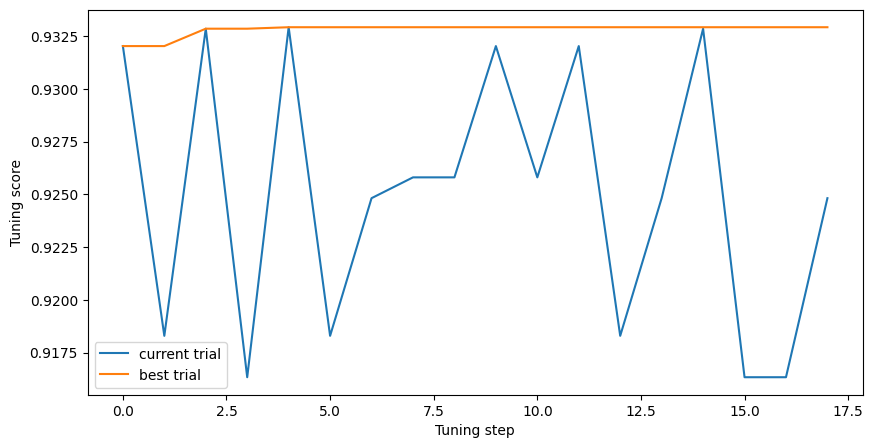

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(tuning_logs["score"], label="current trial")
plt.plot(tuning_logs["score"].cummax(), label="best trial")
plt.xlabel("Tuning step")
plt.ylabel("Tuning score")
plt.legend()
plt.show()

In [ ]:
print('Best Model:\n', tuning_logs[tuning_logs.best].iloc[0])

Best Model:
 score                        0.932924
evaluation_time             97.675218
best                             True
max_depth                          16
growing_strategy    BEST_FIRST_GLOBAL
max_num_nodes                      64
num_trees                         350
Name: 4, dtype: object


### Avaliação de Desempenho

In [ ]:
model.evaluate(X_tst, y_tst)

812/812 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9345


[0.0, 0.9344779849052429]

In [ ]:
y_pred = model.predict(X_tst)
probs = np.column_stack((1-y_pred,y_pred))

812/812 [==============================] - 2s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


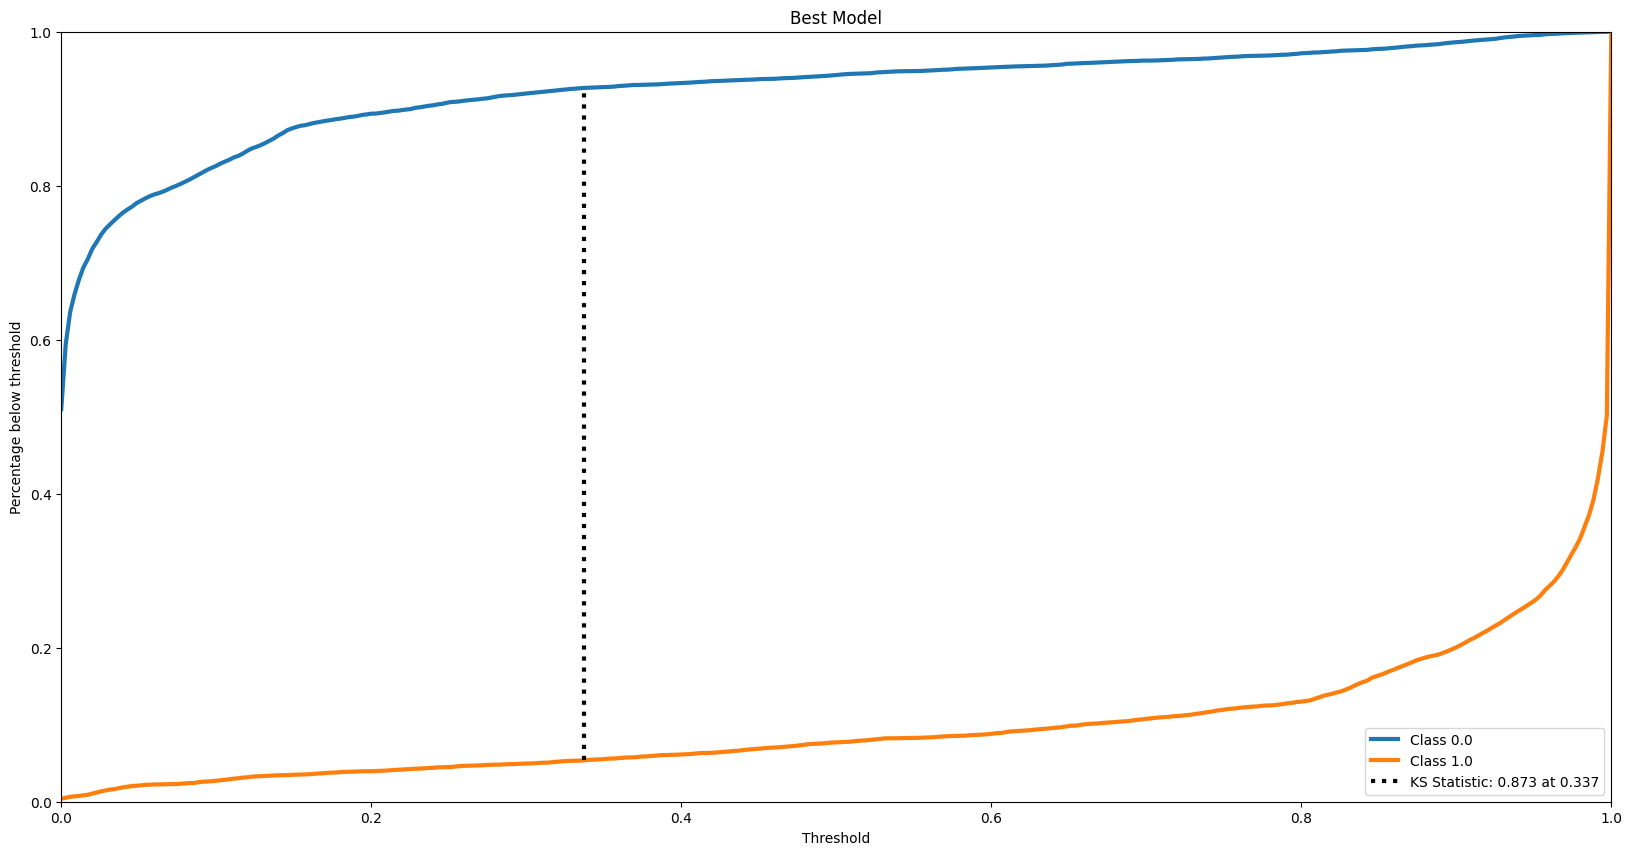

In [ ]:
kscurve(y_tst, probs, 'Best Model')

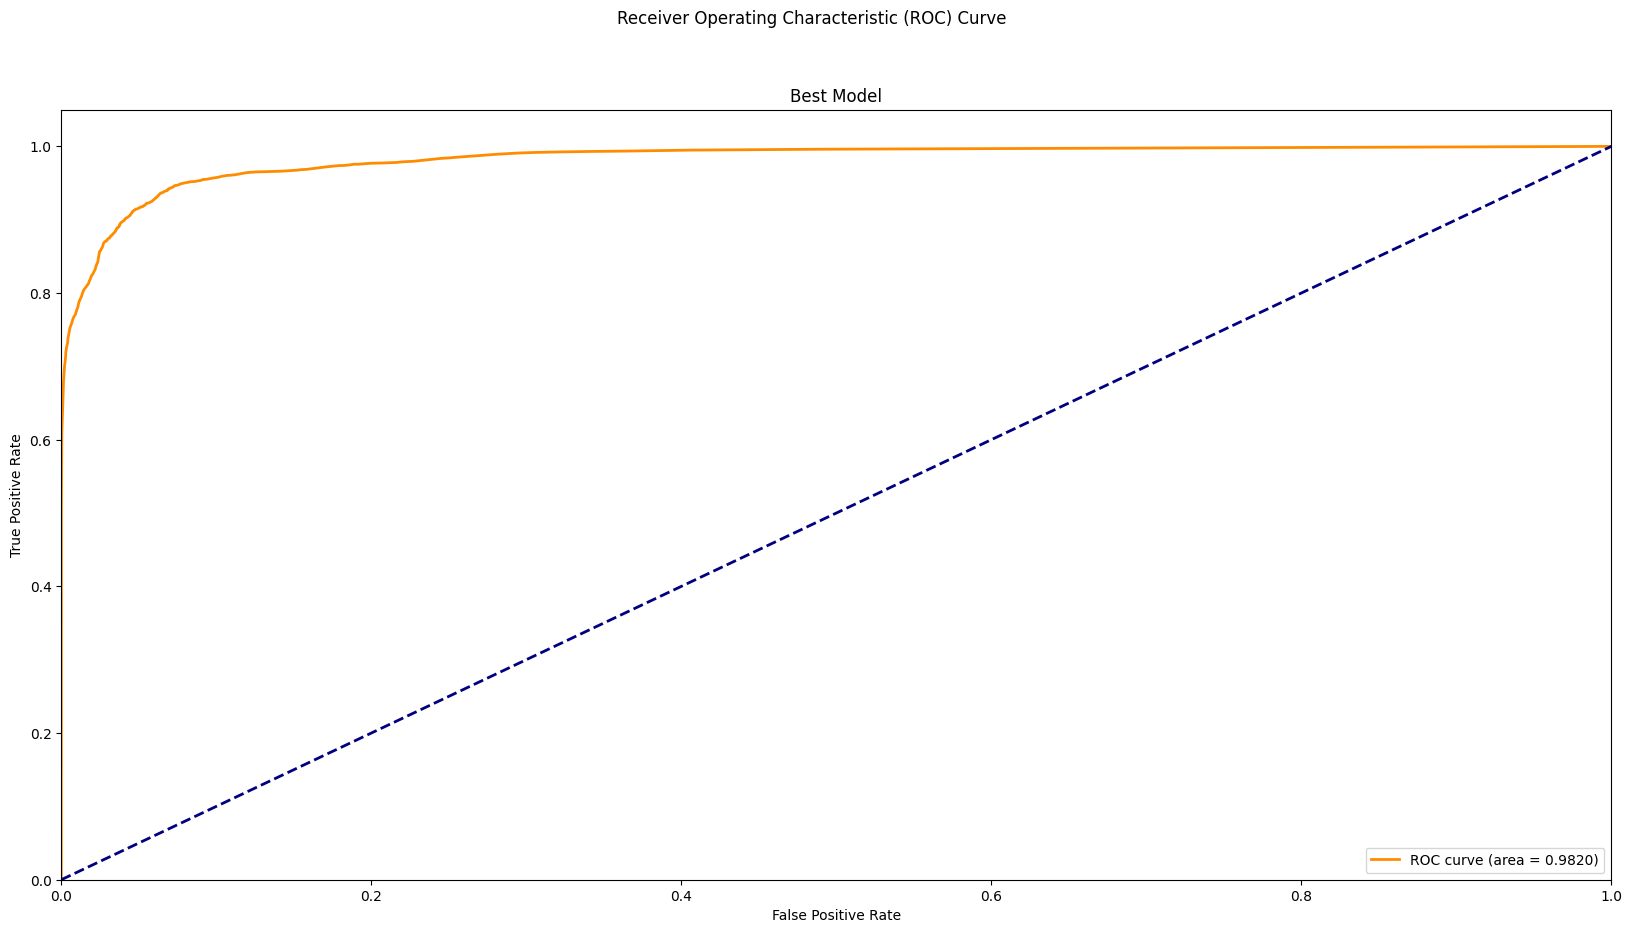

In [ ]:
plotRocCurve(y_tst, y_pred, 'Best Model')

Test acc: 0.9353634123806591


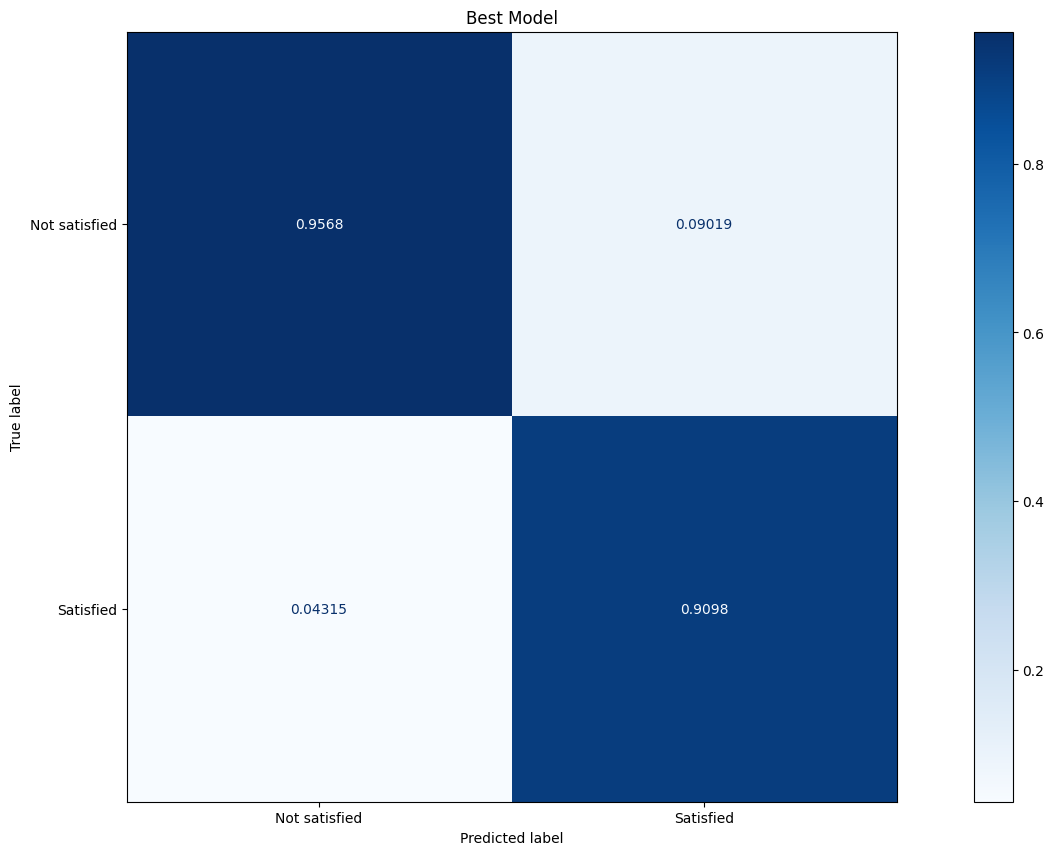

In [ ]:
y_pred_classification = y_pred > 0.337

print('Test acc:', (y_pred_classification == y_tst).sum()/len(y_tst))
plot_confusion(y_tst, y_pred_classification, 'Best Model')

## RF - Scikit

In [ ]:
model = RandomForestClassifier(max_depth=2, random_state=0)

## MLP - Torch

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
def train(model, optimizer, loss_fn, train_dl, valid_dl, epochs, plot_loss = False):
  best_loss = np.infty

  model = model.to(device)
  best_model = model
  model.train()
  train_losses = []
  valid_losses = []

  for epoch in range(epochs):

    acc_loss = []

    for X, y in iter(train_dl):


      X = X.to(device)
      y = y.to(device)

      y_hat = model(X).softmax(dim=1)

      loss = loss_fn(y_hat, y)

      del X, y

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      acc_loss.append(loss.detach().cpu())

    train_losses.append(np.mean(acc_loss))

    acc_loss = []

    for X, y in valid_dl:
      X = X.to(device)
      y = y.to(device)
      y_hat = model(X).softmax(dim=1)
      loss = loss_fn(y_hat, y)
      acc_loss.append(loss.detach().cpu())

    valid_losses.append(np.mean(acc_loss))

    if valid_losses[-1] < best_loss:
      best_loss = valid_losses[-1]
      best_model = model

    if best_loss < 0.05:
      return best_model

    if epoch % 250 == 0:
      print(f'Epoch: {epoch}/{epochs}', f'Best loss: {best_loss}')

    if plot_loss:
      clear_output(wait=True)

      plt.grid()

      plt.plot(train_losses, linestyle = '--', color = "orange", label = 'Train Losses')
      plt.plot(valid_losses, linestyle = '--', color = "blue", label = 'Validation Losses')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')

      plt.legend()

      plt.show()

  return best_model




In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

def aux(train_dl, valid_dl, activation_fn, hidden_layers, lr, dropout, reg):

  clf = MLP(in_channels=22, hidden_channels=hidden_layers, activation_layer=activation_fn, dropout=dropout)
  print(clf)
  clf.train()

  optimizer = optim.SGD(clf.parameters(), lr=lr, weight_decay=reg)
  loss_fn = torch.nn.CrossEntropyLoss()

  best_model = train(clf, optimizer, loss_fn, train_dl, valid_dl, epochs = 20000)

  best_model.eval()

  predicted_train = best_model(X_train_tensor.float().to(device)).argmax(dim=1).cpu().detach()
  predicted_valid = best_model(X_valid_tensor.float().to(device)).argmax(dim=1).cpu().detach()

  return best_model, (accuracy_score(y_valid_tensor, predicted_valid), recall_score(y_valid_tensor, predicted_valid, average='weighted'), precision_score(y_valid_tensor, predicted_valid, average='weighted'), f1_score(y_valid_tensor, predicted_valid, average='weighted'))

In [ ]:
def grid_search(train_dl, valid_dl, activation_fn, hidden_layers, learning_rate, dropout, regularization):
  best_acc = 0
  best_model = None
  args = None

  for act in activation_fn:
    for hl in hidden_layers:
      for lr in learning_rate:
        for drp in dropout:
          for reg in regularization:
            print(f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}')
            model, scores = aux(train_dl, valid_dl, act, hl, lr, drp, reg)
            acc, recall, precision, f1 = scores
            if acc > best_acc:
                best_acc = acc
                best_model = model
                args = f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}'
            print(f'SCORES: acc: {acc}; recall: {recall}; precision: {precision}; f1:{f1}\n')
  print(f"\n\nBest model args: {args}")
  return best_model

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

In [ ]:
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.int64).ravel())

X_valid_tensor = torch.tensor(X_valid.values.astype(np.float32))
y_valid_tensor = torch.tensor(y_valid.values.astype(np.int64).ravel())

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size = 256, shuffle = True, num_workers=2)
valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size = 256, shuffle = True, num_workers=2)

hidden_channels = [[5], [5, 10]]
actv_fns = [torch.nn.ReLU, torch.nn.Sigmoid, torch.nn.Tanh]
learning_rates = [0.1, 0.01]
dropout = [0,0.1]
regularization = [0, 0.01]

#best_model = grid_search(train_dl, valid_dl, actv_fns, hidden_channels, learning_rates, dropout, regularization)


## Gradient Boosting

In [ ]:
tuner = tfdf.tuner.RandomSearch(num_trials=100, trial_num_threads=4)
tuner.choice("max_depth", [16, 20, 24])

tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"])
tuner.choice("max_num_nodes", [16, 32, 64])
tuner.choice("num_trees", [150, 350])

model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner, num_threads=96, loss = 'BINOMIAL_LOG_LIKELIHOOD')

X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train).astype('float32')
X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid).astype('float32')
X_tst, y_tst = np.asarray(X_test.values).astype('float32'), np.asarray(y_test).astype('float32')

model.compile(metrics=["accuracy", "mae"])

history = model.fit(X_t, y_t, validation_data=(X_v, y_v))

Use /tmp/tmp3lg4l1pq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:04.493651. Found 86156 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(29440, shape=(), dtype=int32)
Validation dataset read in 0:00:02.296398. Found 29440 examples.
Training model...
Model trained in 0:17:18.942754
Compiling model...
Model compiled.


In [ ]:
tuning_logs = model.make_inspector().tuning_logs()

tuning_logs

,score,evaluation_time,best,max_depth,growing_strategy,max_num_nodes,num_trees
0,-0.187704,45.825263,False,16,BEST_FIRST_GLOBAL,64,150
1,-0.195548,118.636425,False,16,BEST_FIRST_GLOBAL,16,350
2,-0.186848,191.028947,False,24,BEST_FIRST_GLOBAL,64,350
3,-0.212199,229.672074,False,16,BEST_FIRST_GLOBAL,16,150
4,-0.184560,294.845720,True,16,BEST_FIRST_GLOBAL,64,350
5,-0.195548,368.202120,False,24,BEST_FIRST_GLOBAL,16,350
6,-0.195669,409.557134,False,20,BEST_FIRST_GLOBAL,32,150
7,-0.187764,486.964746,False,16,BEST_FIRST_GLOBAL,32,350
8,-0.187856,563.823075,False,20,BEST_FIRST_GLOBAL,32,350
9,-0.190557,608.424349,False,24,BEST_FIRST_GLOBAL,64,150


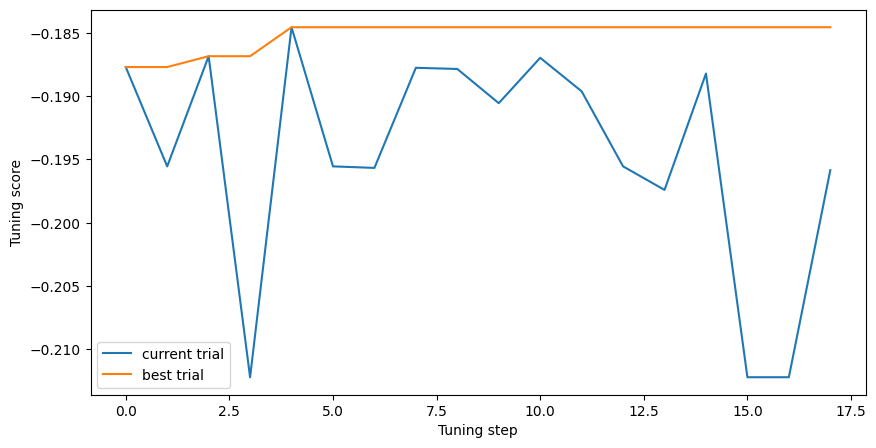

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(tuning_logs["score"], label="current trial")
plt.plot(tuning_logs["score"].cummax(), label="best trial")
plt.xlabel("Tuning step")
plt.ylabel("Tuning score")
plt.legend()
plt.show()

In [ ]:
print('Best Model:\n', tuning_logs[tuning_logs.best].iloc[0])

Best Model:
 score                        -0.18456
evaluation_time             294.84572
best                             True
max_depth                          16
growing_strategy    BEST_FIRST_GLOBAL
max_num_nodes                      64
num_trees                         350
Name: 4, dtype: object


### Avaliação de Desempenho

In [ ]:
model.evaluate(X_tst, y_tst)

812/812 [==============================] - 2s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9619 - mae: 0.0554


[0.0, 0.9618878960609436, 0.05542222410440445]

In [ ]:
y_pred = model.predict(X_tst)
probs = np.column_stack((1-y_pred,y_pred))

812/812 [==============================] - 2s 2ms/step


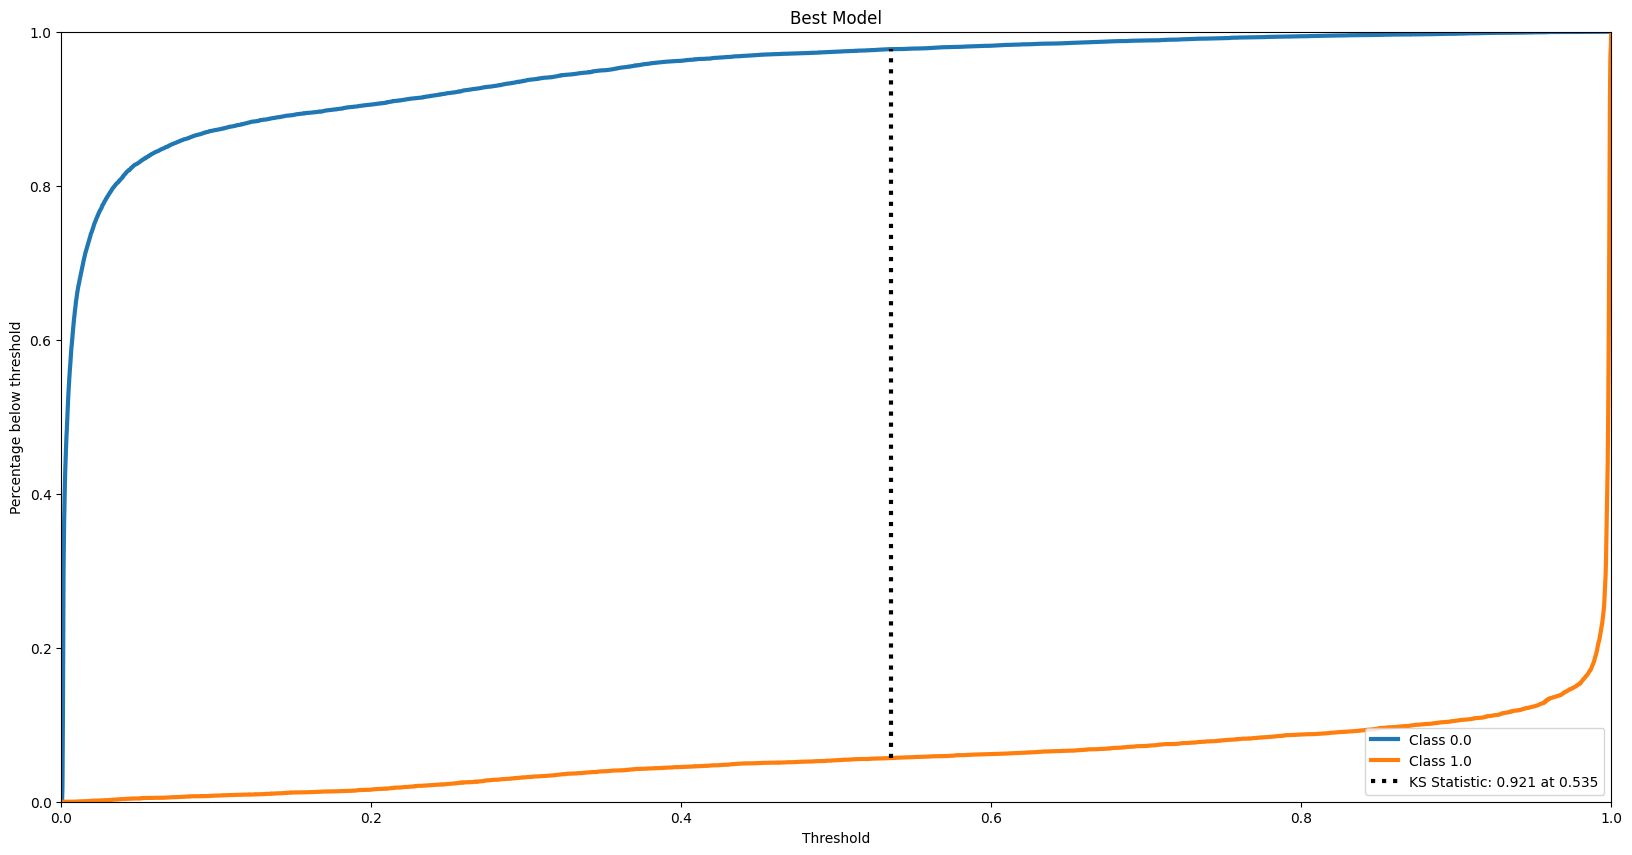

In [ ]:
kscurve(y_tst.ravel(), probs, 'Best Model')

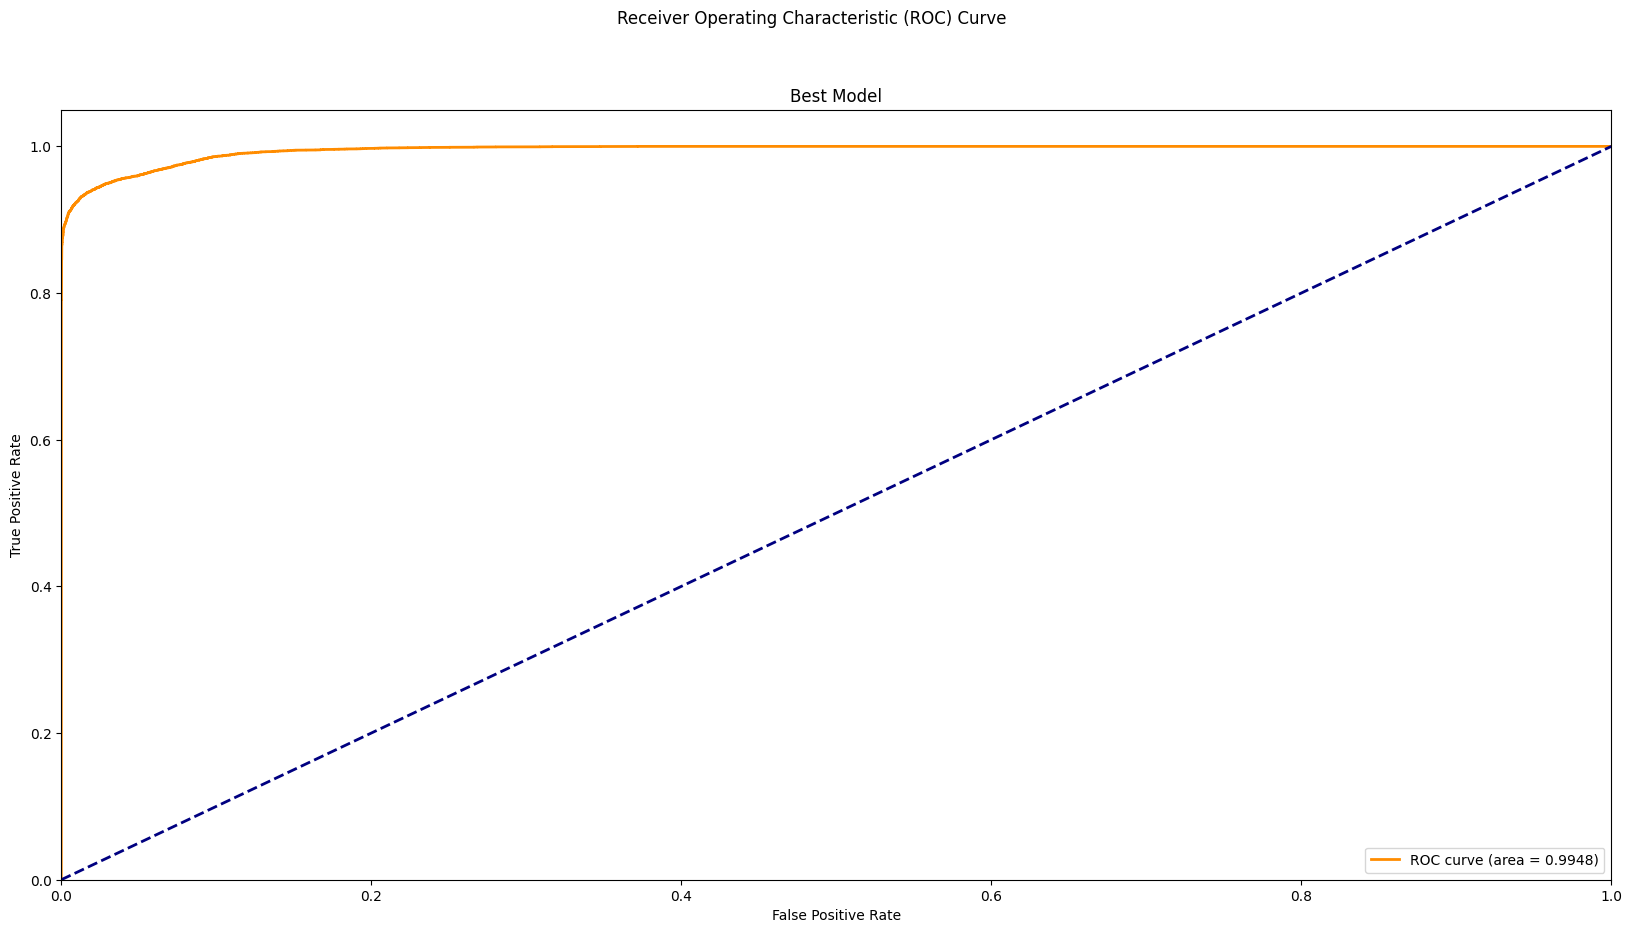

In [ ]:
plotRocCurve(y_tst, y_pred, 'Best Model')

Test acc: 0.9623883584847551


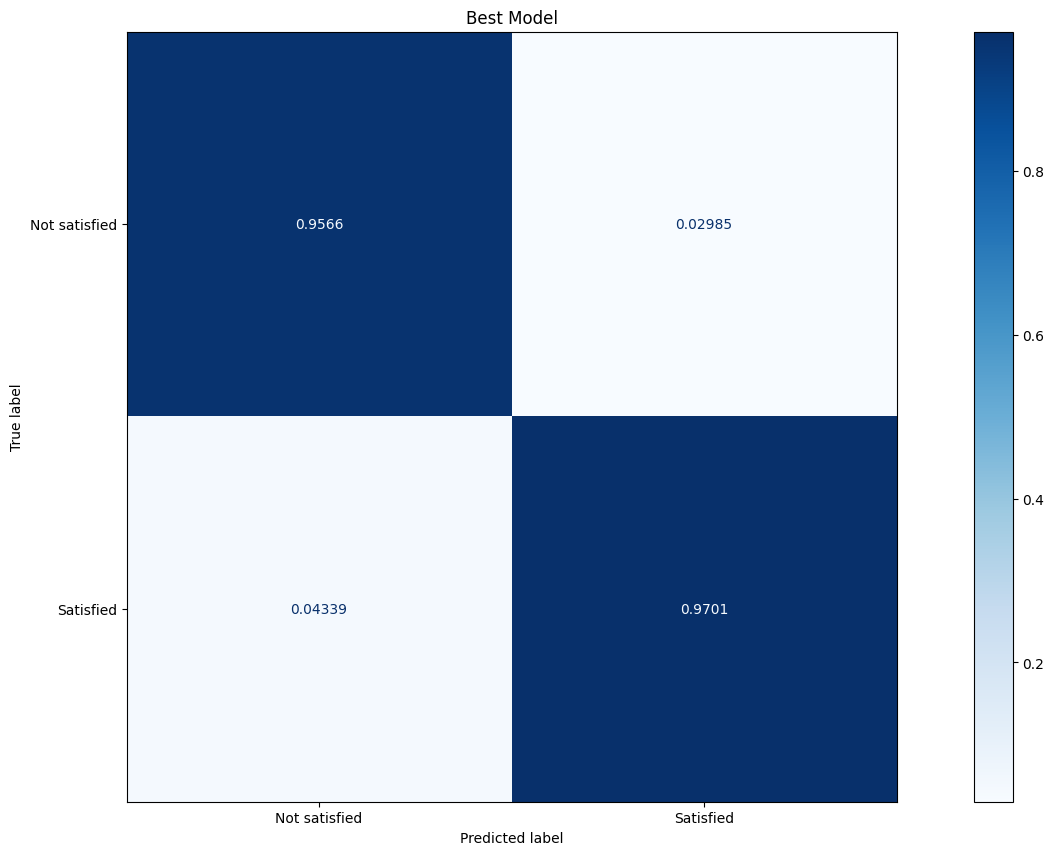

In [ ]:
y_pred_classification = y_pred > 0.535

print('Test acc:', (y_pred_classification == y_tst).sum()/len(y_tst))
plot_confusion(y_tst, y_pred_classification, 'Best Model')

## KAN

In [ ]:
X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train.values).astype('float32').flatten()
X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid.values).astype('float32').flatten()
X_tst, y_tst = np.asarray(X_test.values).astype('float32'), np.asarray(y_test.values).astype('float32')

X_t, y_t = torch.from_numpy(X_t), torch.from_numpy(y_t).type(torch.LongTensor)
X_v, y_v = torch.from_numpy(X_v), torch.from_numpy(y_v).type(torch.LongTensor)
X_tst, y_tst = torch.from_numpy(X_tst), torch.from_numpy(y_tst).type(torch.LongTensor)

In [ ]:
y_t

tensor([1, 0, 1,  ..., 1, 1, 1])

In [ ]:
dataset = {
    'train_input': X_t,
    'train_label': y_t,
    'test_input': X_v,
    'test_label': y_v
}

In [ ]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

In [ ]:
best_model = None
best_results = None

model = None
result = None

def objective(trial):
  global model
  global result

  lmbd = [0.01, 0.1, 0]
  lmbd_ent = [0, 10, 100]
  grid_size = [1, 3, 5, 10]

  lbd = trial.suggest_categorical('Lambda', lmbd)
  lbd_ent = trial.suggest_categorical('Lambda_Entropy', lmbd_ent)
  grid_s = trial.suggest_categorical('Grid', grid_size)


  model = KAN(width=[X_t.shape[1], 2], grid=grid_s, k=3)
  result = model.fit(dataset, lamb=lbd, lamb_entropy=lbd_ent, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(), opt="LBFGS", steps=20)
  acc, loss = result['test_acc'][-1], result['test_loss'][-1].item()

  #trial.set_user_attr(key="model", value=(model, best_result))

  return loss

def callback(study, trial):
    global best_model
    global best_result
    if study.best_trial == trial:
        best_model = model
        best_result = result

study = opt.create_study(direction = 'minimize', pruner = opt.pruners.MedianPruner())
study.optimize(objective, n_trials=100, timeout = 30*60, callbacks=[callback])

# best_model, results = study.user_attrs['best_model']

[I 2024-07-30 15:49:59,171] A new study created in memory with name: no-name-eef612d6-95c4-47bd-a903-7bdafa2c118f


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.24e-01 | test_loss: 4.32e-01 | reg: 3.18e+01 | : 100%|█| 10/10 [05:22<00:00, 32.21s/
[I 2024-07-30 15:55:21,390] Trial 0 finished with value: 0.4324650466442108 and parameters: {'Lambda': 0, 'Lambda_Entropy': 10, 'Grid': 3}. Best is trial 0 with value: 0.4324650466442108.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.82e-01 | test_loss: 4.94e-01 | reg: 2.59e+01 | : 100%|█| 10/10 [06:51<00:00, 41.18s/
[I 2024-07-30 16:02:13,205] Trial 1 finished with value: 0.49367499351501465 and parameters: {'Lambda': 0, 'Lambda_Entropy': 10, 'Grid': 5}. Best is trial 0 with value: 0.4324650466442108.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.11e+00 | test_loss: 2.10e+00 | reg: 1.16e+02 | : 100%|█| 10/10 [05:09<00:00, 31.00s/
[I 2024-07-30 16:07:23,222] Trial 2 finished with value: 2.103147506713867 and parameters: {'Lambda': 0.1, 'Lambda_Entropy': 100, 'Grid': 5}. Best is trial 0 with value: 0.4324650466442108.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.19e-01 | test_loss: 6.20e-01 | reg: 2.29e+00 | : 100%|█| 10/10 [03:37<00:00, 21.72s/
[I 2024-07-30 16:11:00,424] Trial 3 finished with value: 0.6200968623161316 and parameters: {'Lambda': 0.1, 'Lambda_Entropy': 0, 'Grid': 1}. Best is trial 0 with value: 0.4324650466442108.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.93e-01 | test_loss: 8.94e-01 | reg: 1.57e+02 | : 100%|█| 10/10 [04:01<00:00, 24.12s/
[I 2024-07-30 16:15:01,609] Trial 4 finished with value: 0.8940943479537964 and parameters: {'Lambda': 0.1, 'Lambda_Entropy': 100, 'Grid': 1}. Best is trial 0 with value: 0.4324650466442108.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.44e-01 | test_loss: 4.53e-01 | reg: 2.85e+00 | : 100%|█| 10/10 [03:50<00:00, 23.06s/
[I 2024-07-30 16:18:52,232] Trial 5 finished with value: 0.4525867700576782 and parameters: {'Lambda': 0, 'Lambda_Entropy': 0, 'Grid': 1}. Best is trial 0 with value: 0.4324650466442108.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.32e-01 | test_loss: 4.40e-01 | reg: 3.29e+01 | : 100%|█| 10/10 [10:55<00:00, 65.55s/
[I 2024-07-30 16:29:47,827] Trial 6 finished with value: 0.44014832377433777 and parameters: {'Lambda': 0, 'Lambda_Entropy': 10, 'Grid': 10}. Best is trial 0 with value: 0.4324650466442108.


saving model version 0.1


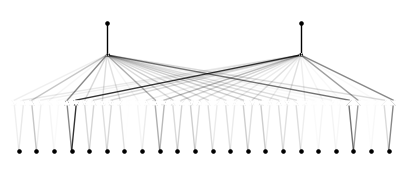

In [ ]:
best_model.plot()

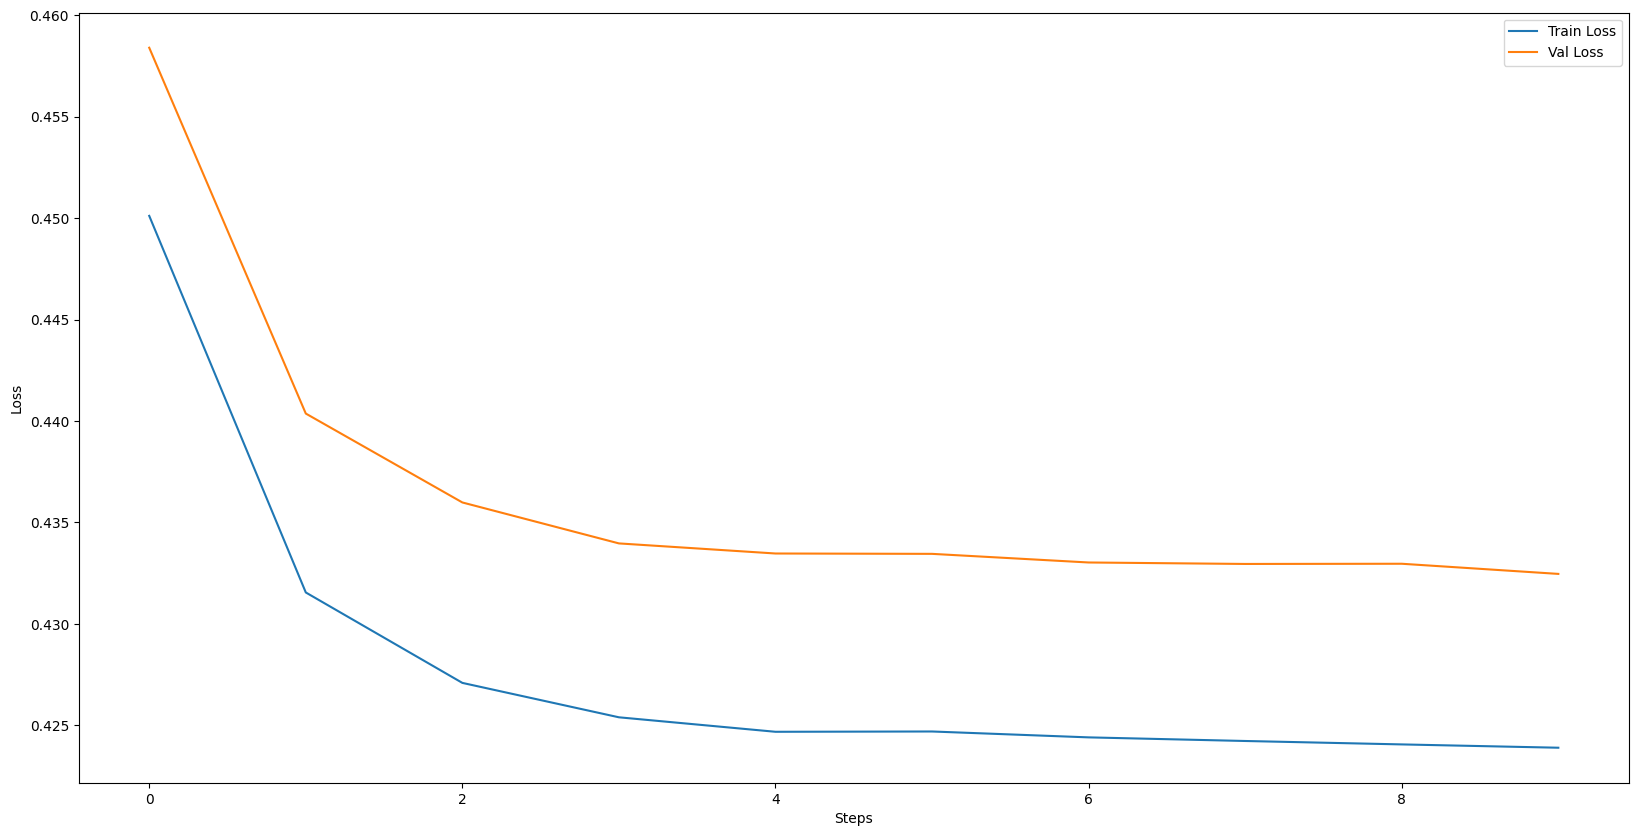

In [ ]:
# Plotar os resultados de losss (opcional)
plt.plot(best_result['train_loss'], label='Train Loss')
plt.plot(best_result['test_loss'], label='Val Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

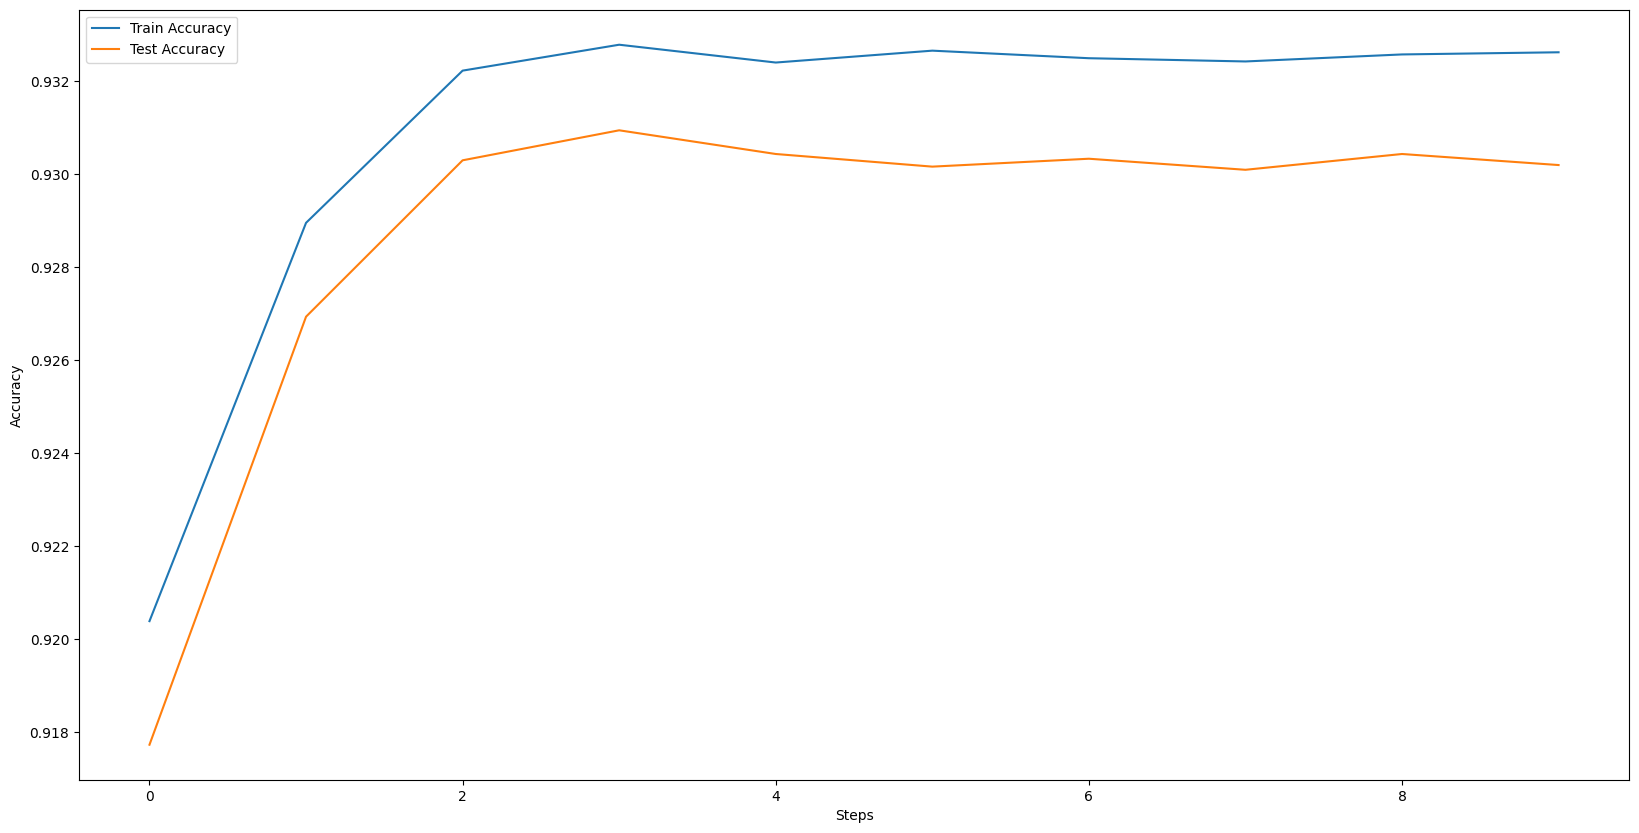

In [ ]:
# Plotar os resultados de acurácia (opcional)
plt.plot(best_result['train_acc'], label='Train Accuracy')
plt.plot(best_result['test_acc'], label='Test Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
study.best_params

{'Lambda': 0, 'Lambda_Entropy': 10, 'Grid': 3}

In [ ]:
opt.visualization.plot_optimization_history(study)

In [ ]:
opt.visualization.plot_param_importances(study)

In [ ]:
opt.visualization.plot_slice(study)

### Avaliação de Desempenho

In [ ]:
dataset = {
    'train_input': X_t,
    'train_label': y_t,
    'test_input': X_tst,
    'test_label': y_tst
}

In [ ]:
#0.5s sobre dataset de teste
y_pred = best_model(X_tst)
probs = special.softmax(y_pred.detach(), axis=1)

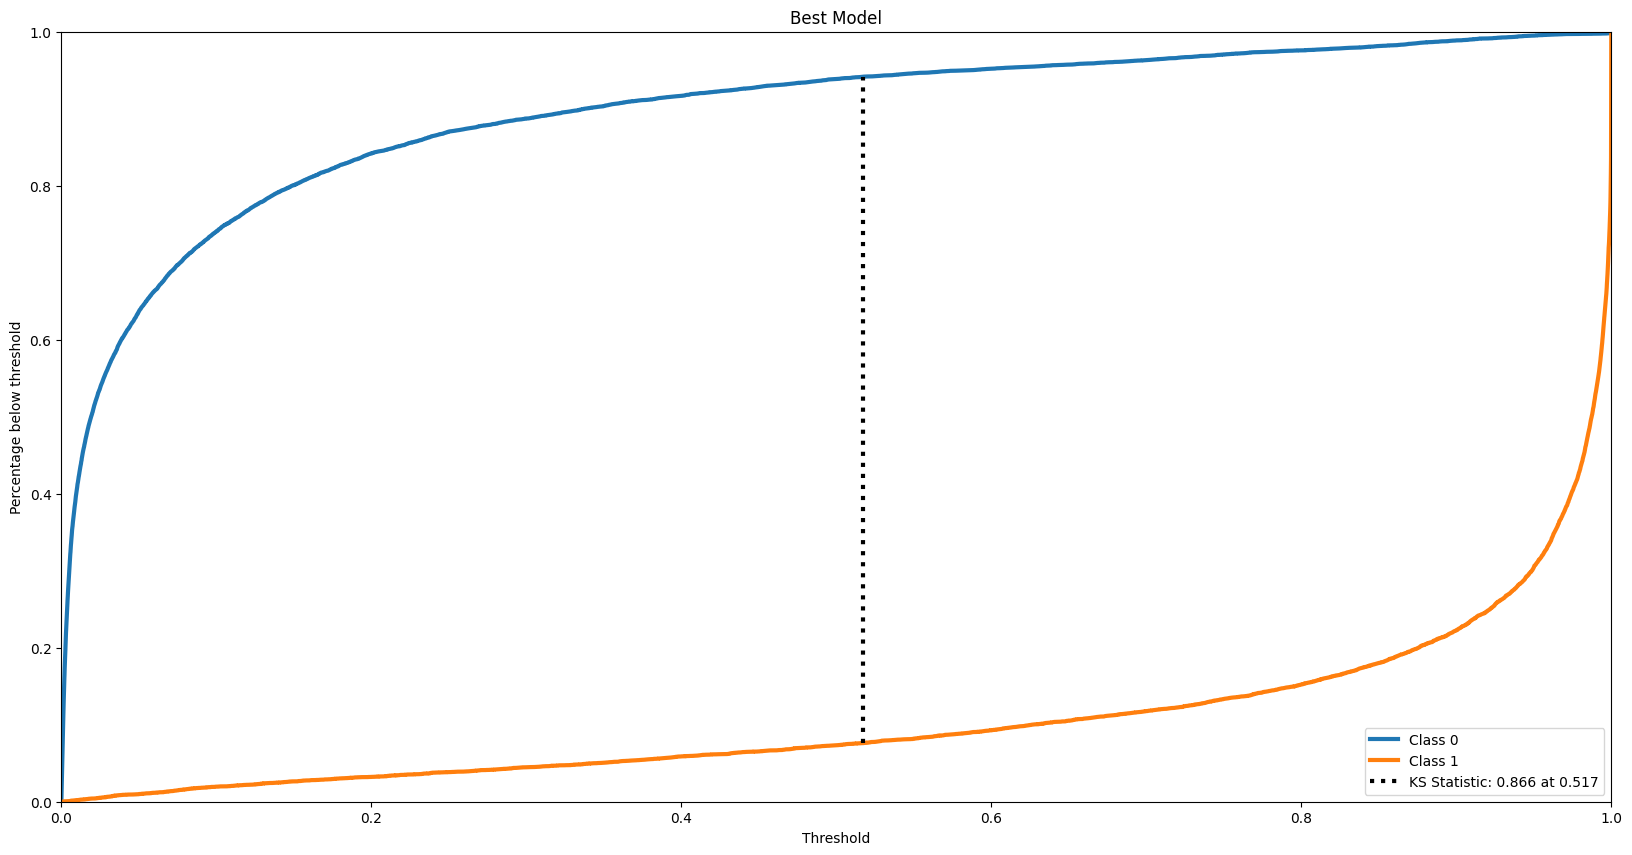

In [ ]:
kscurve(y_tst.ravel(), probs, 'Best Model')

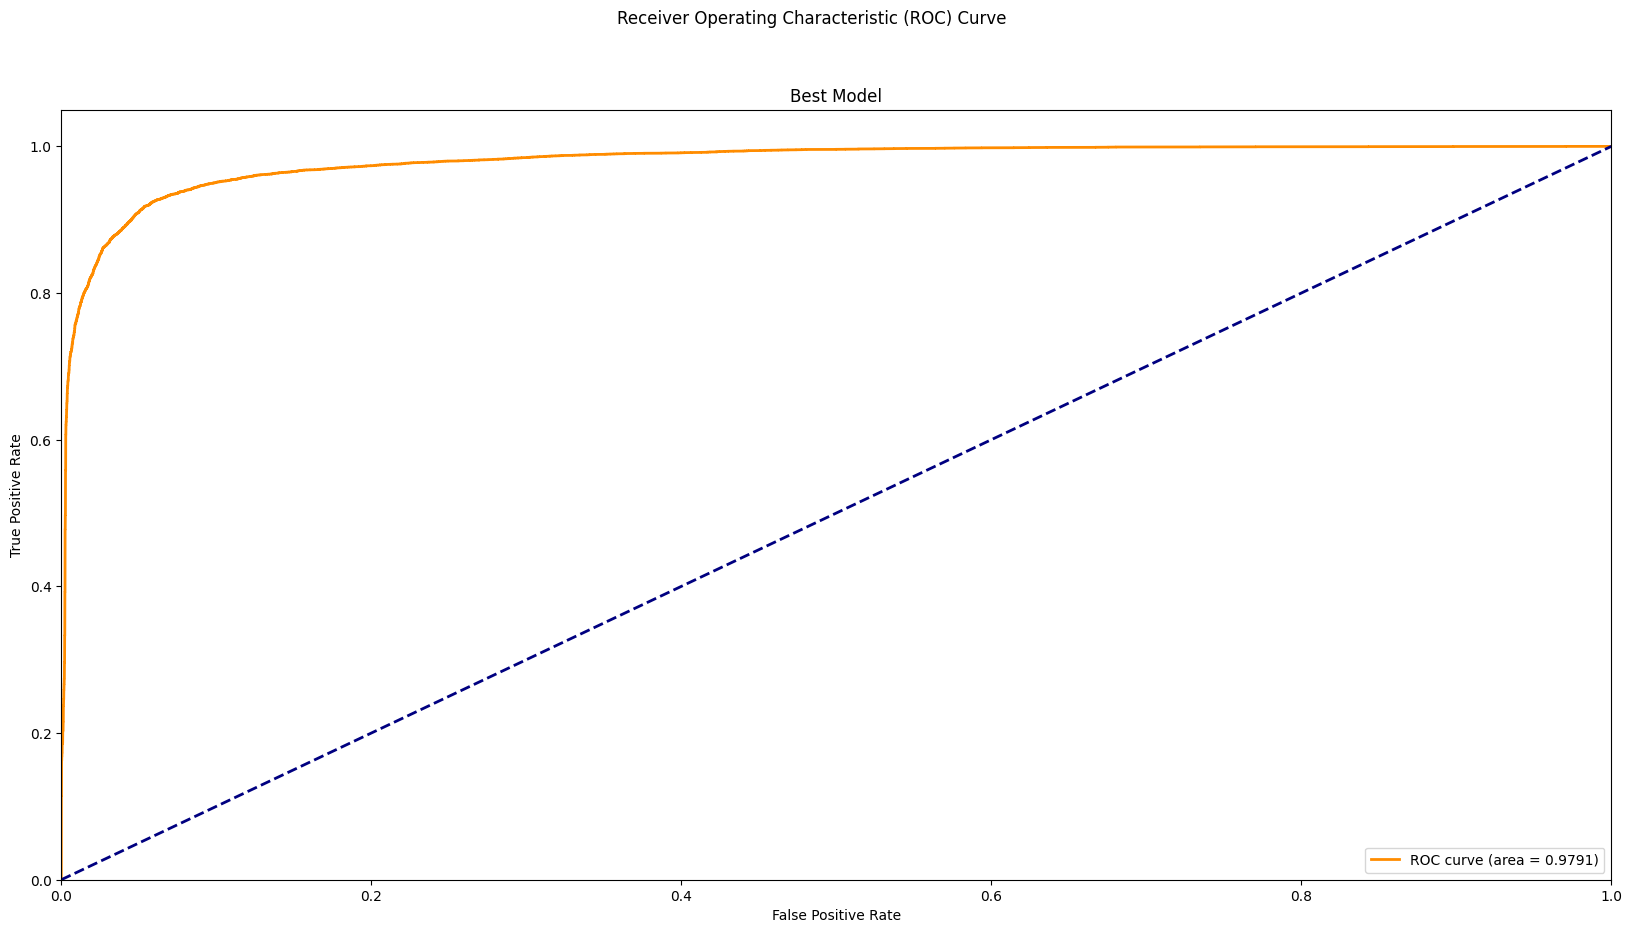

In [ ]:
plotRocCurve(y_tst, probs[:, 1], 'Best Model')

In [ ]:
probs

array([[4.1755251e-04, 9.9958247e-01],
       [1.1199366e-02, 9.8880064e-01],
       [9.9872953e-01, 1.2704106e-03],
       ...,
       [9.9898154e-01, 1.0184665e-03],
       [7.1952172e-02, 9.2804790e-01],
       [9.9990559e-01, 9.4435061e-05]], dtype=float32)

Test acc: 0.9337850323375424


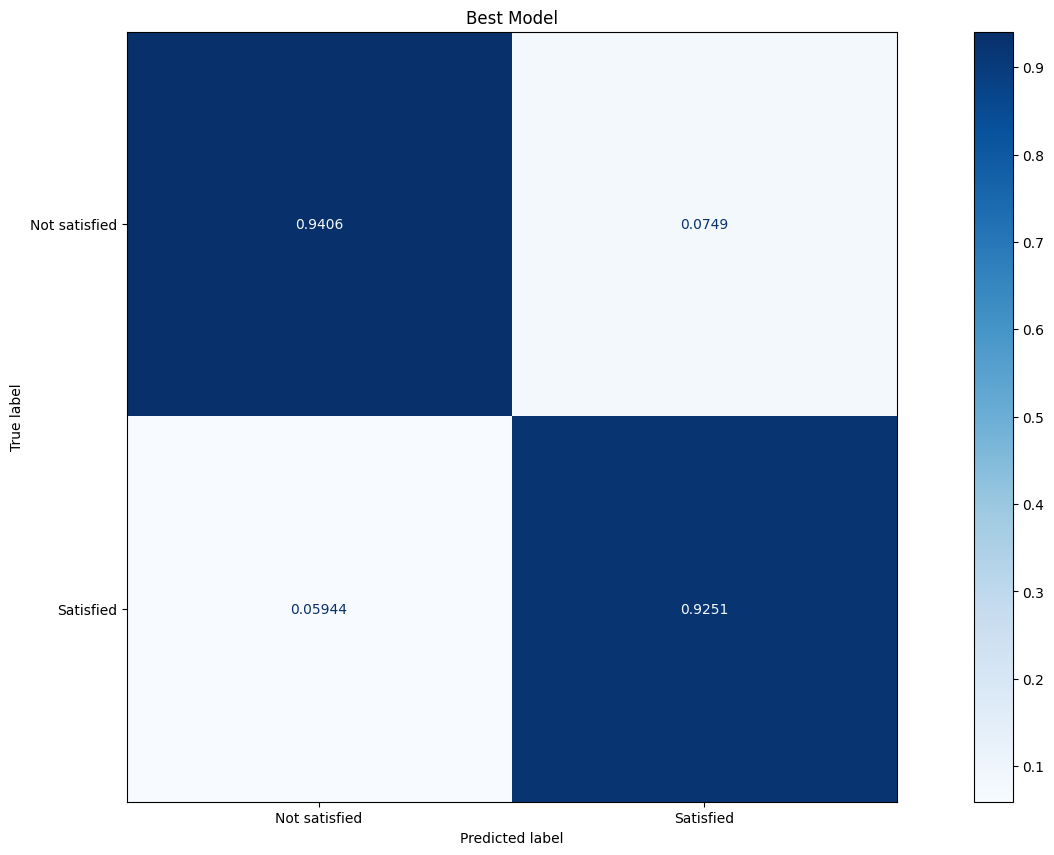

In [ ]:
y_pred_classification = probs > 0.517

print('Test acc:', (y_pred_classification[:, 1] == y_tst.ravel().numpy()).sum()/len(y_tst))
plot_confusion(y_tst, y_pred_classification[:, 1], 'Best Model')

In [ ]:
stats.kstest(y_v, probs[:,1], method='exact')

KstestResult(statistic=0.5, pvalue=0.0, statistic_location=0.0, statistic_sign=1)